# Exercise 1: t-SNE

## Do not start the exercise until you fully understand the submission guidelines.


* The homework assignments are executed automatically. 
* Failure to comply with the following instructions will result in a significant penalty. 
* Appeals regarding your failure to read these instructions will be denied. 
* Kind reminder: the homework assignments contribute 60% of the final grade.


## Read the following instructions carefully:

1. This Jupyter notebook contains all the step-by-step instructions needed for this exercise.
1. Write **efficient**, **vectorized** code whenever possible. Some calculations in this exercise may take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deductions.
1. You are responsible for the correctness of your code and should add as many tests as you see fit to this jupyter notebook. Tests will not be graded nor checked.
1. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/).
1. Your code must run without errors. Use at least `numpy` 1.15.4. Any code that cannot run will not be graded.
1. Write your own code. Cheating will not be tolerated.
1. Submission includes a zip file that contains this notebook, with your ID as the file name. For example, `hw1_123456789_987654321.zip` if you submitted in pairs and `hw1_123456789.zip` if you submitted the exercise alone. The name of the notebook should follow the same structure.
   
Please use only a **zip** file in your submission.

---
---

## Please sign that you have read and understood the instructions: 

### *** YOUR ID HERE ***

203253422

208733253

## Imports


In [1]:
# Import necessary libraries
import time
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Adittional libraries
import torch
from sklearn.model_selection import  ParameterGrid
import pandas as pd
from sklearn.utils import resample


np.random.seed(42)

### Usage of external libraries:

**sklearn**: We used the `sklearn` library to use the TSNE algorithm, parameter grid function, resampling during bootstrap and for their train_test_split function.

**seaborn**: We used the `seaborn` library for adittional plots.

**panads**: We used the `pandas` library for data manipulation during loading and preprocessing.

**torch**: We used the `torch` library for importing optimizers and for the GD algorithm.


# Part 1: Design your algorithm
Make sure to describe the algorithm, its limitations, and describe use-cases.

### t-SNE Algorithm Description

t-SNE (t-Distributed Stochastic Neighbor Embedding) is a non-linear dimensionality reduction algorithm primarily used for visualizing high-dimensional data in 2D or 3D. It aims to preserve the local structure of data by minimizing the divergence between high-dimensional and low-dimensional representations.

---

#### **Cost Function: KL Divergence**
t-SNE minimizes the Kullback-Leibler (KL) divergence between the probability distributions in the original and reduced dimensions:
$C = \sum_{i \neq j} P_{ij} \log \frac{P_{ij}}{Q_{ij}}$

where:
- $ P_{ij} $: Pairwise affinities in the original space.
- $ Q_{ij} $: Pairwise affinities in the reduced space.

---

#### **Perplexity and Beta Estimation**
- **Perplexity**: A key hyperparameter that specifies the effective number of neighbors. It acts as a target to tune the Gaussian kernel bandwidth $\beta = \frac{1}{2\sigma^2}$.
- **Beta Calculation**:
  - For each data point, $\beta$ is optimized such that the conditional distribution matches the target perplexity.
  - Binary search is used to find the optimal $\beta$ for each sample:
    1. Compute pairwise squared Euclidean distances.
    2. Adjust $\beta$ iteratively to match the target perplexity.

---

#### **Optimizers**
The implementation includes multiple optimization strategies for gradient descent:
1. **Adam**: A popular optimizer combining momentum and adaptive learning rates.
2. **Momentum (mt)**: Uses past gradients to accelerate convergence.
3. **Basic Gradient Descent (gd)**: A straightforward method with a fixed learning rate.
4. **Manual Gradient Descent (manual_gd)**: A custom implementation.

The optimizer can be set as a hyperparameter (`opt`) when initializing the t-SNE object.

---

#### **Object-Oriented Implementation**
- The t-SNE algorithm is implemented as an object-oriented class, `CustomTSNE`, encapsulating all methods required for the computation:
  - `fit_transform`: The main entry point for fitting and transforming the data.
  - Helper functions (similar to static methods) for auxiliary calculations, such as `calculate_P`, `calculate_Q`, and `compute_gradient`.
- Each `CustomTSNE` instance represents a single t-SNE model with its parameters (e.g., perplexity, learning rate, optimizer).








---

### Implementation Steps

1. **Compute the Affinities in the Original Dimensions (P)**:
   - Pairwise affinities are calculated using a Gaussian kernel:
   $$
   P_{ij} = \frac{\exp(-\|x_i - x_j\|^2 / 2\sigma_i^2)}{\sum_{k \neq l} \exp(-\|x_k - x_l\|^2 / 2\sigma_i^2)}
   $$
   - Diagonal elements are set to zero $P_{ii} = 0$.
   - $P$ is normalized to sum to 1.

2. **Randomly Generate (Y) in the Low Dimension**:
   - The initial low-dimensional embeddings $Y$ are sampled from a standard normal distribution:
   $$
   Y \sim \mathcal{N}(0, 1e-4)
   $$

3. **Compute the Affinities in the Low Dimensions (Q)**:
   - Pairwise affinities in the low-dimensional space are calculated using a Student-t distribution:
   $$
   Q_{ij} = \frac{(1 + \|y_i - y_j\|^2)^{-1}}{\sum_{k \neq l} (1 + \|y_k - y_l\|^2)^{-1}}
   $$
   - Diagonal elements are set to zero $Q_{ii} = 0$, and $Q$ is normalized.

4. **Optimization method (GD) to Minimize KL Divergence**:
   - The gradient of the cost function with respect to $Y$ is:
   $$
   \frac{\partial C}{\partial Y_i} = 4 \sum_{j \neq i} (P_{ij} - Q_{ij})(Y_i - Y_j)
   $$
   - $Y$ is iteratively updated:
   $$
   Y^{t} = Y^{t-1} - \eta \cdot \frac{\partial C}{\partial Y}
   $$
   where $\eta$ is the learning rate.
   - The optimizer type determines how the gradients are applied (e.g., Adam, momentum, or manual gradient descent). Obviously, in case of optimizers that use momentum, the GD formula is using the momentum as well.

5. **Return the Low-Dimensional Embeddings**:
   - After convergence, the optimized $Y$ represents the low-dimensional embedding.

---

### Functionality and Methodology

1. **Affinity Calculation**:

   High-dimensional affinities $P$ use a Gaussian kernel with a bandwidth adjusted for each sample to match the target perplexity:

      a. **Distribution of Distances**:
         For each sample in the training set, the distribution of distances to all other samples is computed. This step establishes the relationship between the sample and its neighbors in the high-dimensional space.

      b. **Binary Search to Find $\beta$**:
         A **binary search** is performed to find the optimal $\beta$ (where $\beta = \frac{1}{2\sigma^2}$). This ensures that the conditional distribution for each sample matches the target perplexity. The binary search iteratively adjusts $\beta$ until the computed perplexity aligns with the desired value.

      c. **Calculate $P_{ij}$ for Each Sample**:
         Once $\beta$ is determined for a sample, the conditional probability $P_{ij}$ is calculated as:
         $$
         P_{ij} = \frac{\exp(-\beta \|x_i - x_j\|^2)}{\sum_{k \neq i} \exp(-\beta \|x_i - x_k\|^2)}
         $$
         where $P_{ii} = 0$ (diagonal elements are set to zero) and the conditional probabilities (the probabilities per data point) are normalized to sum to 1.
         Then $P$ is symmetrized using $\frac{P_{j|i}+P_{i|j}}{2n}$ to mitigate the outliers problem as mentioned in "Visualizing data using t-sne" by Van der Maaten, Laurens, and Geoffrey Hinton.

   This process ensures that the Gaussian kernel for each sample adapts dynamically to the local density of the data. The resulting pairwise affinities $P_{ij}$ are more meaningful and align with the target perplexity, effectively capturing the underlying structure of the high-dimensional space.


   Low-dimensional affinities $Q$ use a Student-t distribution to handle crowding effects.

2. **Object-Oriented Design**:
   - Encapsulates core functionality in the `CustomTSNE` class.
   - Helper functions support modular and reusable computations.

---

### Use-Cases

1. **Visualization**:
   - t-SNE is widely used to visualize high-dimensional data in 2D or 3D.
   - Useful for identifying clusters or patterns in datasets with known labels.

2. **Feature Extraction**:
   - While not ideal for feature engineering, t-SNE can reduce data dimensionality for exploratory analysis.

This object-oriented and modular implementation ensures flexibility, extensibility, and compatibility with various datasets and optimization strategies.

### Limitations:

1. **High dimensionality**:
    - t-SNE is computationally expensive for high-dimensional data due to the quadratic time complexity of the pairwise distance calculations.
    - For example, images (which are flattened to high-dimensional vectors) may require significant computational resources and time.

2. **Local Minima**:
    - t-SNE is sensitive to initialization and may converge to different local minima for different initializations.
    - The initialization of the low-dimensional embeddings should be done according to the data distribution to avoid poor local minima (For example non-normalized image - the initialization should be distributed with values 0-255).

# Part 2: Implement the Algorithm
You may add new cells, write helper functions or test code as you see fit.
Please use the cell below and include a description of your implementation.
Explain code design consideration, algorithmic choices and any other details you think is relevant to understanding your implementation.
Failing to explain your code will lead to point deductions.

## Helper Functions:

In [2]:
# Note: We used the identity (a-b)^2 = a^2 + b^2 -2a*b in a vectorized form a few times to enhance the calculation efficiency

def compute_perplexity(P):
    """
    Compute the perplexity of the conditional distribution P_i.
    :param P: Matrix of conditional distributions P_i, where each row represents the conditional distribution of data point i.
    :return: Perplexity of the conditional distribution.
    """
    entropy = -np.sum(P * np.log2(P + 1e-10), axis=1) #  Compute entropy of each row
    return np.power(2, entropy)  # Convert entropy to perplexity


def vectorized_P_calculation(distances, betas, symmetrize=False):
    """
    Compute the conditional distribution P for all data points at once using vectorized calculations.
    :param distances: Pairwise distances between data points. A numpy array of shape (n, n) (or m, n for new data points).
    :param betas: Bandwidths for Gaussian kernels. A numpy array of shape (n,).
    :param symmetrize: Whether to symmetrize the conditional distribution. Default is False.
    :return: Conditional distribution P for all data points - a numpy array of shape (n, n).
    """
    
    P = np.exp(-distances * betas[:, np.newaxis])
    np.fill_diagonal(P, 0)
    P /= np.sum(P, axis=1, keepdims=True) + 1e-12  # Normalize row-wise
    if symmetrize:
        P = (P + P.T) / (2*distances.shape[0])  # Symmetrize P
    return P


def generate_low_dimensional_data(n, n_components=2):
    """
    :param n: number of data points
    :return: Y, a numpy array of shape (n, n_components) containing the transformed data
    """
    return 1e-4*np.random.normal(0, 1, size=(n, n_components))


def calculate_Q(Y):
    """
    :param Y: numpy array of shape (n, n_components), where n is the number of data points and n_components is the number of components in the transformed data
    :return: Q, a numpy array of shape (n, n) containing the pairwise affinities in the transformed space
    """
    # Compute pairwise squared Euclidean distances
    squared_diff = np.sum(Y**2, axis=1, keepdims=True)

    pairwise_sq_distances = squared_diff + squared_diff.T - 2 * np.dot(Y, Y.T)

    # Compute the pairwise affinities using a Student-t distribution
    Q = 1 / (1 + pairwise_sq_distances)

    # Set diagonal elements to 0 (For the summation in the denominator)
    np.fill_diagonal(Q, 0)

    # Divide the pairwise affinities by the sum of the pairwise affinities
    Q /= np.sum(Q)

    return Q


def compute_kl_divergence(P, Q):
    """
    Compute the KL divergence between P and Q, handling diagonal zeros.
    :param P: numpy array of shape (n, n), pairwise affinities in the original space
    :param Q: numpy array of shape (n, n), pairwise affinities in the transformed space
    :return: KL divergence value
    """
    epsilon = 1e-10
    Q = np.clip(Q, epsilon, None)  # Ensure Q > 0

    # Mask out the diagonal
    mask = ~np.eye(P.shape[0], dtype=bool)  # Boolean mask where diagonal is False

    # Compute KL divergence excluding diagonal elements
    kl_div = np.sum(P[mask] * np.log(P[mask] / Q[mask]))

    return kl_div

## Custom t-SNE Implementation

In [3]:
class CustomTSNE:
    def __init__(self, perplexity=30.0, n_components=2, n_iter=1000, learning_rate=200.0, opt="adam"):
        self.perplexity = perplexity # perplexity is a measure of the effective number of neighbors. It is analogous to the number of nearest neighbors k that is employed in many manifold learners.
        self.n_components = n_components # number of components in the transformed. Default is 2D
        self.n_iter = n_iter # number of iterations for the optimization. Default is 1000
        self.learning_rate = learning_rate # learning rate for the optimization. Default is 200.0
        self.opt = opt  # Optimizer for gradient descent: "adam", "mt" (momentum), "gd" (gradient descent) using PyTorch or "manual_gd" for manual gradient descent
 
            
    def calculate_P(self, X):
        """
        :param X: numpy array of shape (n, d), where n is the number of data points and d is the number of dimensions
        :return: P, a numpy array of shape (n, n) containing the pairwise affinities
        """
        # Compute pairwise squared Euclidean distances
        squared_diff = np.sum(np.square(X), axis=1, keepdims=True)  # n x 1
        pairwise_sq_distances = squared_diff + squared_diff.T - 2 * np.dot(X, X.T)  # n x n
        pairwise_sq_distances = np.maximum(pairwise_sq_distances, 0)  # Avoid negative values
        np.fill_diagonal(pairwise_sq_distances, 0)  # Set diagonal elements to 0

        # Compute beta for each point | beta - bandwidth of the Gaussian kernel that is used for the conditional probability distribution (1/sigma^2)
        betas = self.binary_search_beta(pairwise_sq_distances)

        # Compute affinities using betas
        return vectorized_P_calculation(pairwise_sq_distances, betas, True)


    def binary_search_beta(self, distances, max_iter=50, tol=1e-1):
        """
        Perform binary search to find the optimal beta for a single row of distances.

        :param distances: Pairwise squared distances between all data points. A numpy array of shape (n, n) (or m, n for new data points)
        :param max_iter: Maximum number of binary search iterations
        :param tol: Tolerance for convergence
        :return: betas, 1D numpy array of shape (n,), optimal beta values for each point
        """
        n = distances.shape[0]
        beta_low, beta_high = np.ones(n) * 0.1, np.ones(n) * 10
        betas = 0.5*np.ones(n)  # Initialize beta

        for _ in range(max_iter):
            P = vectorized_P_calculation(distances, betas)
            current_perplexity = compute_perplexity(P) # Compute the perplexity of the conditional distribution for each point. Shape: (n,)

            # Compute the difference between current and target perplexity (target is self.perplexity) element-wise
            diff = current_perplexity - self.perplexity

            # Check for convergence
            if np.all(abs(diff) < tol):
                break

            # Update beta based on the difference
            too_high = diff > 0  # current_perplexity > target, beta too low
            beta_low[too_high] = betas[too_high]
            betas[too_high] = (beta_low[too_high] + beta_high[too_high]) / 2

            too_low = diff < 0  # current_perplexity < target, beta too high
            beta_high[too_low] = betas[too_low]
            betas[too_low] = (beta_low[too_low] + beta_high[too_low]) / 2

        return betas
    

    def compute_gradient(self, P, Q, Y):
        """
        Compute the gradient of the t-SNE cost function with respect to Y without using 3D tensors.

        :param P: numpy array of shape (n, n), pairwise affinities in the original space
        :param Q: numpy array of shape (n, n), pairwise affinities in the transformed space
        :param Y: numpy array of shape (n, n_components), low-dimensional embeddings
        :return: grad, numpy array of shape (n, n_components), gradient with respect to Y
        """
        # Compute pairwise squared distances
        sum_Y = np.sum(Y**2, axis=1, keepdims=True)  # Sum of squares for each point (n, 1)
        pairwise_sq_distances = sum_Y + sum_Y.T - 2 * np.dot(Y, Y.T)  # (n, n)

        # Compute the normalization term
        norm_term = 1 + pairwise_sq_distances  # Add 1 to squared distances
        inv_norm_term = 1 / norm_term  # Invert the normalization term (n, n)

        # Compute coefficients (P - Q) scaled by the normalization term
        coeff = (P - Q) * inv_norm_term  # Shape (n, n)

        # Compute the gradient
        return 4 * (np.sum(coeff, axis=1, keepdims=True) * Y - np.dot(coeff, Y))

    
    def fit_manually(self, P, Y):
        """
        Fit the data to the t-SNE algorithm using gradient descent.
        :param P: numpy array of shape (n, n), containing the pairwise affinities in the original space
        :param Y: numpy array of shape (n, n_components), where n is the number of data points and n_components is the number of components in the transformed data
        :return: Y, a numpy array of shape (n, n_components) containing the transformed data after gradient descent
        """

        Q = calculate_Q(Y) # compute pairwise affinities in the transformed space. n x n matrix

        costs = [compute_kl_divergence(P, Q)] # list to store the cost at each iteration
        print(f'Initial cost: {costs[0]}')

        # implement gradient descent to minimize the loss function
        for i in range(self.n_iter):
            if i%10 == 0: print(f'Iteration number: {i}, previous cost value: {costs[-1]}')
            dY = self.compute_gradient(P, Q, Y)
            Y -= self.learning_rate*dY # update Y
            Q = calculate_Q(Y) # compute pairwise affinities in the transformed space. n x n matrix
            costs.append(compute_kl_divergence(P, Q)) # compute cost

        print(f'Final cost: {costs[-1]}')
        return Y, costs
    

    def fit(self, P, Y):
        """
        Fit the data to the t-SNE algorithm using PyTorch optimizers.
        :param P: numpy array of shape (n, n), containing the pairwise affinities in the original space
        :param Y: numpy array of shape (n, n_components), initial low-dimensional representation
        :return: Y, a numpy array of shape (n, n_components) containing the transformed data
        """

        # Convert inputs to PyTorch tensors
        P = torch.tensor(P, dtype=torch.float32)
        Y = torch.tensor(Y, dtype=torch.float32, requires_grad=True)  # Enable gradients for Y

        # Choose the optimizer based on `self.opt`
        if self.opt == "adam":
            optimizer = torch.optim.Adam([Y], lr=self.learning_rate)
        elif self.opt == "mt":
            optimizer = torch.optim.SGD([Y], lr=self.learning_rate, momentum=0.9)
        else:  # Default to basic gradient descent
            optimizer = torch.optim.SGD([Y], lr=self.learning_rate)

        # List to store costs for analysis
        costs = []

        # Iterative optimization
        for i in range(self.n_iter):
            optimizer.zero_grad()  # Clear previous gradients

            # Compute Q directly in PyTorch
            pairwise_sq_distances = torch.cdist(Y, Y, p=2) ** 2  # Pairwise squared distances
            Q = 1 / (1 + pairwise_sq_distances)  # Student-t kernel
            Q.fill_diagonal_(0)  # Set diagonal to 0
            Q /= Q.sum()  # Normalize Q

            # Compute KL divergence
            cost = torch.sum(P * torch.log(P / (Q + 1e-10) + 1e-10))
            costs.append(cost.item())

            if i % 10 == 0:
                print(f"Iteration {i}, Cost: {cost.item()}")

            # Compute the gradient and update
            cost.backward()  # Compute gradients
            optimizer.step()  # Update Y

        print(f"Final cost: {costs[-1]}")

        # Convert Y back to NumPy array
        return Y.detach().numpy(), costs


    
    def fit_transform(self, X):
        """
        :param X: numpy array of shape (n, d), where n is the number of data points and d is the number of dimensions
        :return: Y, a numpy array of shape (n, n_components) containing the transformed data
        """
        print("Starting tsne")
        P = self.calculate_P(X) # compute pairwise affinities in the original space. n x n matrix

        init_y = generate_low_dimensional_data(X.shape[0]) # randomly generate low-dimensional data

        if self.opt == "manual_gd":
            return self.fit_manually(P, init_y)
        else:
            return self.fit(P, init_y)


    def plots_costs(self, costs):
        """
        :param costs: list containing the cost at each iteration
        Plots the cost at each iteration
        """
        plt.plot(costs)
        plt.title(f'Learning Rate: {self.learning_rate}, Number of Iterations: {self.n_iter}, Perplexity: {self.perplexity}')
        plt.xlabel('Iterations')
        plt.ylabel('Cost')
        plt.show()

    # Part 5: Transformation of New Data Points

    def transform(self, X_original, Y_original, X_new):
        """
        Transform new data points into the existing lower-dimensional space.
        :param X_original: numpy array of shape (n, d), original high-dimensional data
        :param Y_original: numpy array of shape (n, d_low), corresponding low-dimensional embeddings
        :param X_new: numpy array of shape (m, d), new high-dimensional data points
        :return: Y_new, numpy array of shape (m, d_low), projected embeddings for the new points
        """
        # Compute pairwise squared distances between X_new and X_original using the formula (x-y)^2 = x^2 + y^2 - 2xy | shape: (m, n)
        sq_distances = np.sum(X_new**2, axis=1, keepdims=True) + \
                                np.sum(X_original**2, axis=1, keepdims=True).T - \
                                2 * np.dot(X_new, X_original.T)
        
        # Compute betas for each point in X_new using binary search | shape: (m,)
        betas = self.binary_search_beta(sq_distances)

        # Compute affinities between using betas
        affinities = np.exp(-sq_distances * betas[:, np.newaxis])

        # Normalize row-wise - Divide each row by the sum of the row for each point in X_new before multiplying by Y_original in order to "preserve" the relative distances
        affinities /= np.sum(affinities, axis=1, keepdims=True)

        # Compute the low-dimensional embedding for new points using the normalized affinities
        Y_new = np.dot(affinities, Y_original)
        
        return Y_new

### Test the algorithm on a simple dataset

#### Learn TSNE object

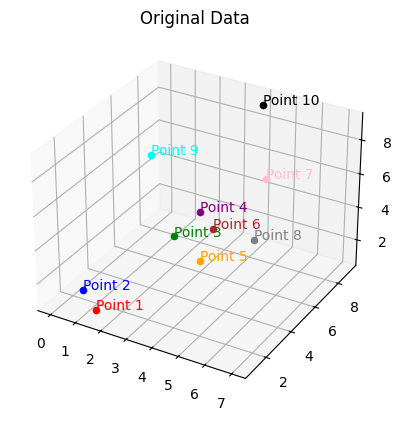

Starting tsne
Iteration 0, Cost: 0.7040483951568604
Iteration 10, Cost: 0.7040444016456604
Iteration 20, Cost: 0.702511727809906
Iteration 30, Cost: 0.5647647380828857
Iteration 40, Cost: 0.3863796591758728
Iteration 50, Cost: 0.29944416880607605
Iteration 60, Cost: 0.2253320962190628
Iteration 70, Cost: 0.182472363114357
Iteration 80, Cost: 0.15889650583267212
Iteration 90, Cost: 0.14454619586467743
Iteration 100, Cost: 0.1348918080329895
Iteration 110, Cost: 0.12791599333286285
Iteration 120, Cost: 0.12263582646846771
Iteration 130, Cost: 0.11851457506418228
Iteration 140, Cost: 0.11522795259952545
Iteration 150, Cost: 0.11256416887044907
Iteration 160, Cost: 0.11037815362215042
Iteration 170, Cost: 0.1085655689239502
Iteration 180, Cost: 0.10704942047595978
Iteration 190, Cost: 0.10577180981636047
Iteration 200, Cost: 0.1046876385807991
Iteration 210, Cost: 0.10376190394163132
Iteration 220, Cost: 0.10296639055013657
Iteration 230, Cost: 0.10227827727794647
Iteration 240, Cost: 0.10

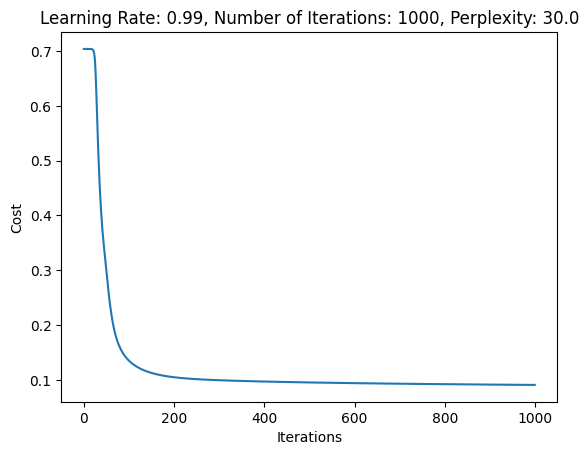

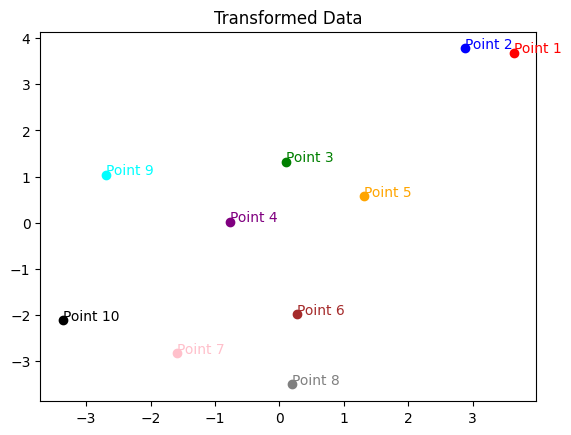

In [4]:
# Generate 10 scatterd points in 3D
X = np.array([[1.5, 1, 1], [1, 1, 2], [3, 4, 4], [3.5, 5, 5], [4, 4, 3], [5, 3, 6], [6, 5, 8], [7, 2, 7], [0, 8, 5], [4, 9, 9]])
# 10 colors labels 
labels = ["red", "blue", "green", "purple", "orange", "brown", "pink", "gray", "cyan", "black"]
# Plot the original data in 3D with colored labels
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(len(X)):
    ax.scatter(X[i, 0], X[i, 1], X[i, 2], color=labels[i], label=f"Point {i + 1}")
    ax.text(X[i, 0], X[i, 1], X[i, 2], f"Point {i + 1}", color=labels[i])  # Add text labels
plt.title('Original Data')

plt.show()

tsne = CustomTSNE(learning_rate=0.99, opt="gd")
Y, cost = tsne.fit_transform(X)
tsne.plots_costs(cost)

# Plot the transformed data in 2D with matching colored labels
plt.figure()
for i in range(len(Y)):
    plt.scatter(Y[i, 0], Y[i, 1], color=labels[i], label=f"Point {i + 1}")
    plt.text(Y[i, 0], Y[i, 1], f"Point {i + 1}", color=labels[i])  # Add text labels
plt.title('Transformed Data')

plt.show()


#### Map new data points to the existing low-dimensional space

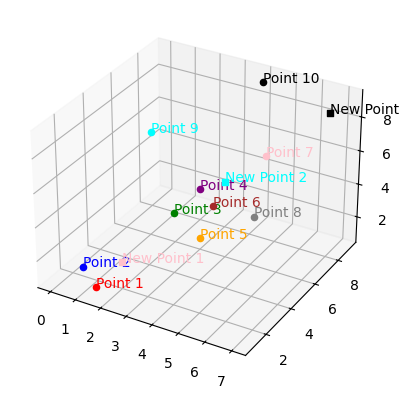

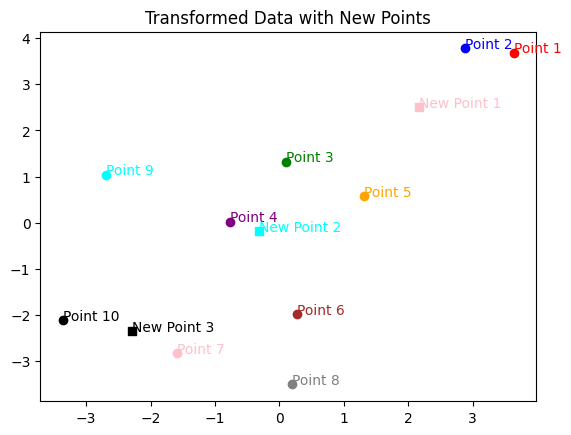

In [5]:
# Test transform method on new data points
X_new = np.array([[2, 2, 2], [4, 6, 5], [7, 8, 9]])
Y_new = tsne.transform(X, Y, X_new)

# Plot the original and new data points in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot original data points
for i in range(len(X)):
    ax.scatter(X[i, 0], X[i, 1], X[i, 2], color=labels[i], label=f"Point {i + 1}")
    ax.text(X[i, 0], X[i, 1], X[i, 2], f"Point {i + 1}", color=labels[i])  # Add text labels

# Plot new data points as squares 
new_labels = ["pink", "cyan", "black"]
for i in range(len(X_new)):
    ax.scatter(X_new[i, 0], X_new[i, 1], X_new[i, 2], color=new_labels[i], marker='s', label=f"New Point {i + 1}")
    ax.text(X_new[i, 0], X_new[i, 1], X_new[i, 2], f"New Point {i + 1}", color=new_labels[i])  # Add text labels

    
# Plot the original and new data points in 2D
plt.figure()
for i in range(len(Y)):
    plt.scatter(Y[i, 0], Y[i, 1], color=labels[i], label=f"Point {i + 1}")
    plt.text(Y[i, 0], Y[i, 1], f"Point {i + 1}", color=labels[i])  # Add text labels

for i in range(len(Y_new)):
    plt.scatter(Y_new[i, 0], Y_new[i, 1], color=new_labels[i], marker='s', label=f"New Point {i + 1}")
    plt.text(Y_new[i, 0], Y_new[i, 1], f"New Point {i + 1}", color=new_labels[i])  # Add text labels

plt.title('Transformed Data with New Points')

plt.show()

## Cross-Validation using Bootstrap for hyperparameters (perplexity, learning rate, optimization algorithm)

In [6]:
def bootstrap_val_tsne(X, y, param_grid, tsne_class, num_bootstraps=10, n_iter=500):
    """
    Perform bootstrap validation to tune t-SNE hyperparameters, including perplexity, learning rate, and optimizer.

    :param X: numpy array of shape (n, d), high-dimensional data
    :param y: numpy array of shape (n,), integer labels for each point
    :param param_grid: dict, contains ranges of 'perplexity', 'learning_rate', and 'opt'
    :param tsne_class: t-SNE class to instantiate and test
    :param num_bootstraps: int, number of bootstrap iterations for each hyperparameter combination
    :param n_iter: int, fixed number of iterations for t-SNE optimization
    :return: best_params, dict with the optimal hyperparameter values
    """
    grid = ParameterGrid(param_grid)
    best_score = float('inf')
    best_params = None
    results = []

    # Iterate over each parameter combination
    for params in grid:
        perplexity = params['perplexity']
        learning_rate = params['learning_rate']
        opt = params['opt']
        print(f"Testing perplexity={perplexity}, learning_rate={learning_rate}, opt={opt}, n_iter={n_iter}")

        bootstrap_costs = []

        # First iteration: No replacement (original data)
        tsne = tsne_class(perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter, opt=opt)
        Y, costs = tsne.fit_transform(X)
        bootstrap_costs.append(costs[-1])  # Save the final cost

        # Plot scatter for the first iteration
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(Y[:, 0], Y[:, 1], s=5, c=y.astype(int), cmap='tab10')
        plt.colorbar(scatter)
        plt.title(f"t-SNE Scatter Plot | Perplexity={perplexity}, Learning Rate={learning_rate}, Opt={opt}")
        plt.xlabel("Y[0]")
        plt.ylabel("Y[1]")
        plt.show()

        # Subsequent iterations: Bootstrap with replacement
        for _ in range(num_bootstraps - 1):
            X_sampled = resample(X, replace=True, random_state=None)

            # Initialize and fit t-SNE on the resampled data
            tsne = tsne_class(perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter, opt=opt)
            _, costs = tsne.fit_transform(X_sampled)

            # Save the final cost of this bootstrap iteration
            bootstrap_costs.append(costs[-1])

        # Average the bootstrap costs for this hyperparameter combination
        avg_cost = np.mean(bootstrap_costs)
        print(f"Average bootstrap cost: {avg_cost}")

        # Store results for plotting
        results.append((perplexity, learning_rate, opt, avg_cost))

        # Update the best parameters
        if avg_cost < best_score:
            best_score = avg_cost
            best_params = params

    print(f"Best parameters: {best_params}, with cost: {best_score}")

    # Convert results to a structured array for easy plotting
    results_array = np.array(results, dtype=[('perplexity', float), ('learning_rate', float), ('opt', 'U10'), ('cost', float)])
    return best_params, results_array


def plot_all_combinations(results_array):
    """
    Plot all combinations of t-SNE hyperparameters in a single plot of costs.
    Each permutation is assigned a unique color, with a legend for better clarity.
    
    :param results_df: pandas DataFrame with columns: perplexity, learning_rate, opt, cost
    """

    # Convert to a pandas DataFrame for easier plotting
    results_df = pd.DataFrame(results_array)

    # display the table of results sorted by cost
    results_df = results_df.sort_values(by='cost')
    print(results_df)
    
    # Assign a unique color to each permutation
    color_map = plt.cm.tab10  # Use the 'tab10' colormap

    # Create a scatter plot with annotations and a legend for permutations
    plt.figure(figsize=(14, 8))
    for index, row in results_df.iterrows():
        # Plot each point with its assigned color
        plt.scatter(
            row["perplexity"], row["cost"], 
            color=color_map(index % 10),  # Use modulo to cycle through colors
            label=f"P={row['perplexity']}, LR={row['learning_rate']}, OPT={row['opt']}",
            s=100, alpha=0.7
        )
        # Annotate the cost value on the plot
        plt.text(
            row["perplexity"], 
            row["cost"], 
            f"{row['cost']:.2f}",  # Display cost with two decimal places
            fontsize=10, 
            ha='center', 
            va='bottom'
        )

    # Add a legend for the permutations
    plt.legend(title="Permutations", loc="upper right", bbox_to_anchor=(1.3, 1), fontsize=9)
    plt.title("t-SNE Hyperparameter Tuning: Costs and Parameters")
    plt.xlabel("Perplexity")
    plt.ylabel("Cost")
    plt.grid(True)
    plt.show()

## Justification of Algorithm Design



### Hyperparameter Tuning Using Bootstrap

To tune the hyperparameters, we employ **bootstrap sampling** for evaluation, which we studied in class and found to be the most suitable method for t-SNE. This is because the loss of a "validation set" does not adequately reflect the quality of the t-SNE mapping. 

Bootstrap sampling works as follows:
1. A smaller subset of the dataset is used for computational efficiency.
2. **Sampling with replacement** is performed $k$ times to create multiple resampled datasets.
3. The t-SNE algorithm is trained on each resampled dataset, and the corresponding loss is computed.
4. The **average loss** across all resampled datasets is used to evaluate the hyperparameter configuration.

By using bootstrap, we ensure that the selected hyperparameters generalize better to the data, and the noise in the sampling process simulates robustness in the optimization.

---

### Considerations and Characteristics

#### Efficient Implementation
- The implementation minimizes loops, with the only loop being for gradient descent (number of iterations).
- All calculations are vectorized using matrix operations to achieve computational efficiency.

**Example - Pairwise Distance Calculation**:
The pairwise squared Euclidean distances are calculated without explicit loops:
$$
D_{ij} = \|x_i - x_j\|^2 = \|x_i\|^2 + \|x_j\|^2 - 2 x_i^T x_j
$$
Implemented in Python:
```python
squared_diff = np.sum(X**2, axis=1, keepdims=True)
pairwise_sq_distances = squared_diff + squared_diff.T - 2 * np.dot(X, X.T)
```

#### Scalable to Data Size
- Leveraging matrix multiplication ensures that affinity calculations in both high- and low-dimensional spaces are efficient.
- The use of PyTorch optimizers (e.g., SGD or momentum) enhances scalability, allowing the algorithm to handle large datasets effectively.

#### Convergence

The t-SNE algorithm minimizes the KL divergence between the high-dimensional affinities $P$ and low-dimensional affinities $Q$, converging to a local minimum:

$$
C = \sum_{i \neq j} P_{ij} \log \frac{P_{ij}}{Q_{ij}}
$$

This convergence ensures that the local structure of the high-dimensional data is preserved in the low-dimensional space.


----

### Hyperparameters

#### **Perplexity**:
- The perplexity parameter controls the conditional distribution of distances in the high-dimensional space $P$.

**Effect of Perplexity**:
- **Low Perplexity**: The algorithm fails to "capture" the structure of the distribution, resulting in arbitrary scatter.
- **High Perplexity**: The algorithm produces overly grouped distributions, with all samples clustering together in the low-dimensional space.

**Recommended Range**:
- We observed that perplexity should be approximately **30–500**, depending on the number of labels and samples.



#### **Learning Rate**:
- The learning rate and number of iterations are critical for convergence and must be tuned based on the dataset size and dimensions.
- Unlike other learning algorithms where the learning rate is typically smaller than 1, in t-SNE, the learning rate should be around **200** for effective convergence.



#### **Optimizer**:
- While Adam is not particularly relevant for the dataset sizes we experimented with, we found that both **momentum** and **gradient descent (GD)** using PyTorch performed efficiently and achieved good results.



#### **Number of Iterations**:
- Typically, the algorithm converges after approximately **1000 iterations**, reaching a local minimum of the KL divergence.



# Part 3: Demonstrate the Algorithm
Please use the cell below to discuss your dataset choice and why it is appropriate (or not) for this algorithm.

## Dataset



We chose to demonstrate our algorithm on the MNIST dataset. The advantages of MNIST are:

1. **Multiple Labels**:
   - MNIST contains multiple labels, which allows us to visualize the samples clearly in the lower dimension based on their labels.
   - Each label exhibits distinct properties, such as similarities and dissimilarities with other labels and a range of values, making it an ideal dataset for clustering and visualization tasks.

2. **Type of Data**:
   - **High Dimensionality**: The MNIST dataset consists of images with dimensions of \(28 \times 28\), which translates to 784 features per sample (After flattenning). This high dimensionality makes it well-suited for demonstrating the capabilities of t-SNE.
   - **Pixel-Based Features**: Unlike tabular data, where some features may have high correlations with the label, MNIST's features represent pixel values. This ensures that no individual feature disproportionately influences the outcome, making the dataset more challenging and realistic for dimensionality reduction.
   - **Structured Patterns**: The images in MNIST are relatively simple and contain common patterns for each label. These patterns make the data easier to interpret and visualize, while still retaining enough complexity to challenge the algorithm.
   - **Low Number of Outliers**: MNIST is a clean dataset with minimal outliers, ensuring that the results primarily reflect the algorithm's effectiveness rather than data noise.

3. **Well-Studied Dataset**:
   - MNIST is a benchmark dataset used in a variety of machine learning tasks. Its widespread use ensures comparability with other techniques and provides a familiar context for evaluation.

4. **Visualization Benefits**:
   - The dataset's well-defined clusters (corresponding to digits) provide an excellent demonstration of how t-SNE separates and visualizes data in lower dimensions, making it ideal for showcasing the strengths of the algorithm.


## Preprocess



1. **Dataset Import**:
   - We chose to import the dataset from the Hugging Face library. This library provides high reliability in processing across various Python versions, along with helpful documentation and code examples for importing datasets.

2. **Custom Import Function**:
   - We created a function to import the dataset for a given number of points and test ratio.
   - The dataset is imported as a `DatasetDict` object, which organizes the data into training and test splits.

3. **Splitting and Conversion**:
   - The dataset is split into training and test sets with features and labels based on the provided dictionary structure.
   - The data is converted to NumPy arrays because our t-SNE algorithm expects input in this format.

4. **Normalization**:
   - Values are normalized to the range [0, 1]. This ensures compatibility with our distance measurement methods, probability distribution calculations, and the initialization of \( Y \) (random initializations in the lower dimensions).

5. **Flattening**:
   - The data is flattened into vectors. While this may compromise the spatial structure of the original data (images), t-SNE operates on vectors and requires this transformation.

6. **Sampling**:
   - We slice the dataset to include $n_{\text{points}}$ for different hyperparameter tuning or algorithm testing options.
   - The test set is created by taking a fraction (based on the ratio) of $n_{\text{points}}$.

7. **Sanity Check**:
   - A plot of the labels is generated to verify the mix of labels in the data. This ensures that the dataset is well-distributed and suitable for further analysis.

---

### Post-Preprocessing Step:
After preprocessing, we apply **bootstrapping** for hyperparameter optimization, as described in the algorithm design section.


## Load the dataset and preprocess

In [7]:
from datasets import load_dataset # Load the dataset from the Hugging Face Datasets library

def import_mnist_dataset(n_points = 1000, test_size=0.2):
    """
    Import the MNIST dataset and return the train and test data.
    :param n_points: Number of train points to return
    :param test_size: Fraction of the dataset to include in the test split
    :return: X_train, X_test, y_train, y_test
    """
    # Load the MNIST dataset from datasets library as DatasetDict object
    ds = load_dataset("mnist")

    # Split the data into train and test and convert to NumPy arrays
    X_train, X_test, y_train, y_test = np.array(ds['train']['image']), np.array(ds['test']['image']), np.array(ds['train']['label']), np.array(ds['test']['label'])

    # Normalize the data to [0, 1]
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0

    # Flatten the images
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

    # Take n_points from the train data
    X_train, y_train = X_train[:n_points], y_train[:n_points]

    # Take n_points*test_size from the test data
    X_test, y_test = X_test[:int(n_points*test_size)], y_test[:int(n_points*test_size)]

    print(f'Shapes: X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}')

    return X_train, X_test, y_train, y_test

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Shapes: X_train: (10000, 784), y_train: (10000,), X_test: (2000, 784), y_test: (2000,)


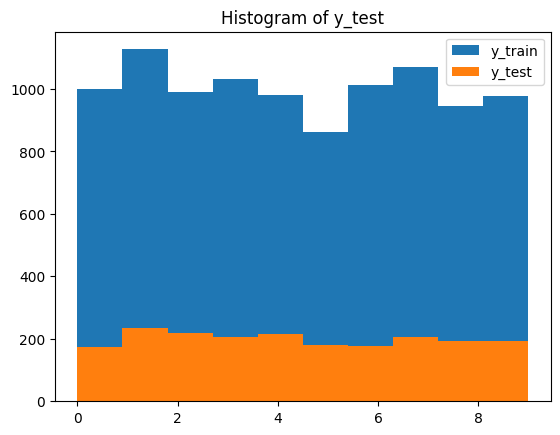

In [8]:
X_train, X_test, y_train, y_test = import_mnist_dataset(n_points=10000, test_size=0.2)

# plot histogram of y_train and y_test
plt.hist(y_train)
plt.title('Histogram of y_train')

plt.hist(y_test)
plt.title('Histogram of y_test')

plt.legend(['y_train', 'y_test'])

plt.show()

## Apply bootstrapping for hyperparameter optimization

#### 1000 points, 500 iterations

Test different permutations of hyperparameters to find the best combination according to the cost function (after every test there is a plot of the cost function and table with sorted results).

In [9]:
X_tr, X_te, y_tr, y_te = import_mnist_dataset(n_points=1000, test_size=0.2)

Shapes: X_train: (1000, 784), y_train: (1000,), X_test: (200, 784), y_test: (200,)


#### first bootstrap:

**Perplexity**: 5, 10, 30

**Learning Rate**: 50, 100, 200

**Optimizer**: Momentum, GD

Testing perplexity=5, learning_rate=50, opt=momentum, n_iter=500
Starting tsne
Iteration 0, Cost: 4.987329006195068
Iteration 10, Cost: 4.987329006195068
Iteration 20, Cost: 4.987326145172119
Iteration 30, Cost: 4.987269401550293
Iteration 40, Cost: 4.985869407653809
Iteration 50, Cost: 4.9535441398620605
Iteration 60, Cost: 4.7079315185546875
Iteration 70, Cost: 4.361003398895264
Iteration 80, Cost: 4.104870319366455
Iteration 90, Cost: 3.914987564086914
Iteration 100, Cost: 3.7647347450256348
Iteration 110, Cost: 3.6402981281280518
Iteration 120, Cost: 3.534066915512085
Iteration 130, Cost: 3.4414563179016113
Iteration 140, Cost: 3.359454870223999
Iteration 150, Cost: 3.285989284515381
Iteration 160, Cost: 3.219545364379883
Iteration 170, Cost: 3.158977746963501
Iteration 180, Cost: 3.1034598350524902
Iteration 190, Cost: 3.05234694480896
Iteration 200, Cost: 3.0050885677337646
Iteration 210, Cost: 2.9612128734588623
Iteration 220, Cost: 2.920335292816162
Iteration 230, Cost: 2.88215

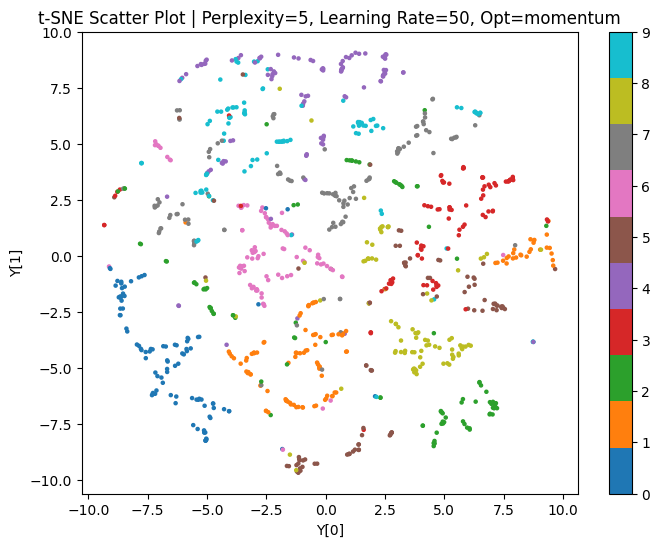

Starting tsne
Iteration 0, Cost: 5.186367988586426
Iteration 10, Cost: 5.186367988586426
Iteration 20, Cost: 5.186361789703369
Iteration 30, Cost: 5.186202049255371
Iteration 40, Cost: 5.181788444519043
Iteration 50, Cost: 5.101853370666504
Iteration 60, Cost: 4.779759883880615
Iteration 70, Cost: 4.443724155426025
Iteration 80, Cost: 4.198902606964111
Iteration 90, Cost: 4.012701988220215
Iteration 100, Cost: 3.8627371788024902
Iteration 110, Cost: 3.737334728240967
Iteration 120, Cost: 3.6297264099121094
Iteration 130, Cost: 3.5355937480926514
Iteration 140, Cost: 3.451988458633423
Iteration 150, Cost: 3.376795530319214
Iteration 160, Cost: 3.308450937271118
Iteration 170, Cost: 3.2457821369171143
Iteration 180, Cost: 3.187917947769165
Iteration 190, Cost: 3.13421630859375
Iteration 200, Cost: 3.084172487258911
Iteration 210, Cost: 3.037358522415161
Iteration 220, Cost: 2.9934210777282715
Iteration 230, Cost: 2.9520676136016846
Iteration 240, Cost: 2.91304087638855
Iteration 250, Cos

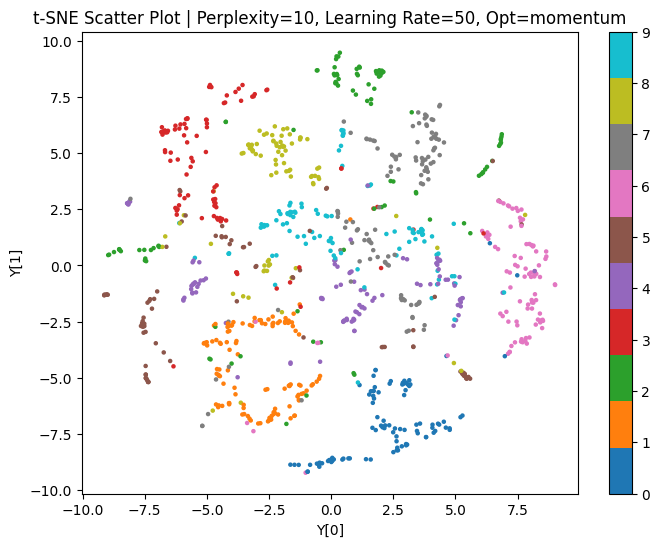

Starting tsne
Iteration 0, Cost: 4.715763092041016
Iteration 10, Cost: 4.715763092041016
Iteration 20, Cost: 4.71575927734375
Iteration 30, Cost: 4.715665340423584
Iteration 40, Cost: 4.713130474090576
Iteration 50, Cost: 4.663632392883301
Iteration 60, Cost: 4.396279335021973
Iteration 70, Cost: 4.056791305541992
Iteration 80, Cost: 3.8078861236572266
Iteration 90, Cost: 3.621306896209717
Iteration 100, Cost: 3.473008632659912
Iteration 110, Cost: 3.350698232650757
Iteration 120, Cost: 3.246905565261841
Iteration 130, Cost: 3.1567912101745605
Iteration 140, Cost: 3.077241897583008
Iteration 150, Cost: 3.006176471710205
Iteration 160, Cost: 2.942049980163574
Iteration 170, Cost: 2.883668899536133
Iteration 180, Cost: 2.8301291465759277
Iteration 190, Cost: 2.780740976333618
Iteration 200, Cost: 2.7349395751953125
Iteration 210, Cost: 2.692241907119751
Iteration 220, Cost: 2.6522421836853027
Iteration 230, Cost: 2.6146135330200195
Iteration 240, Cost: 2.579099655151367
Iteration 250, Co

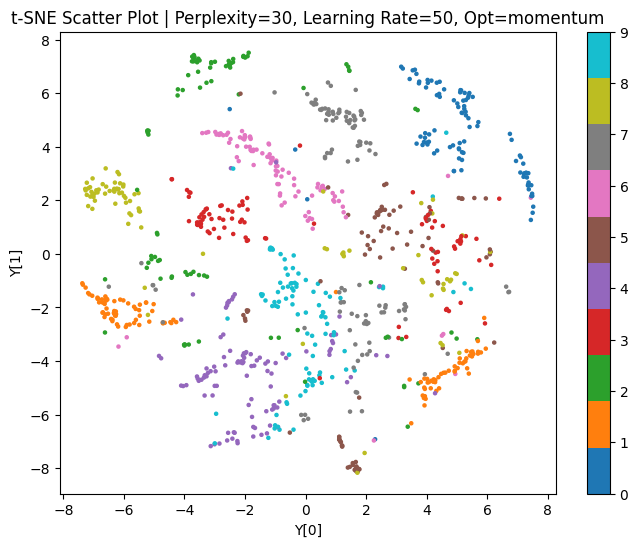

Starting tsne
Iteration 0, Cost: 4.174012184143066
Iteration 10, Cost: 4.174012184143066
Iteration 20, Cost: 4.174009323120117
Iteration 30, Cost: 4.173948287963867
Iteration 40, Cost: 4.172320365905762
Iteration 50, Cost: 4.141661643981934
Iteration 60, Cost: 3.9821314811706543
Iteration 70, Cost: 3.6934573650360107
Iteration 80, Cost: 3.4347596168518066
Iteration 90, Cost: 3.2450826168060303
Iteration 100, Cost: 3.0990960597991943
Iteration 110, Cost: 2.980820417404175
Iteration 120, Cost: 2.881779193878174
Iteration 130, Cost: 2.79685640335083
Iteration 140, Cost: 2.7227396965026855
Iteration 150, Cost: 2.6571173667907715
Iteration 160, Cost: 2.598255157470703
Iteration 170, Cost: 2.5448737144470215
Iteration 180, Cost: 2.496063709259033
Iteration 190, Cost: 2.451134443283081
Iteration 200, Cost: 2.409526824951172
Iteration 210, Cost: 2.3708107471466064
Iteration 220, Cost: 2.334648609161377
Iteration 230, Cost: 2.3007545471191406
Iteration 240, Cost: 2.2688844203948975
Iteration 25

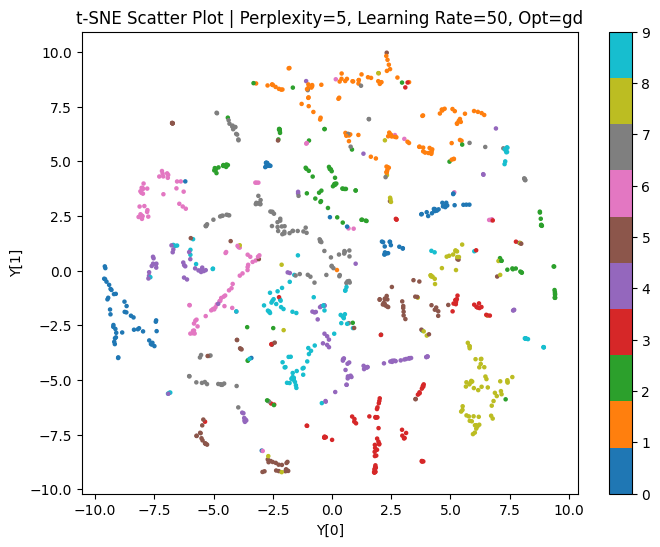

Starting tsne
Iteration 0, Cost: 5.148200511932373
Iteration 10, Cost: 5.148200511932373
Iteration 20, Cost: 5.148195266723633
Iteration 30, Cost: 5.148071765899658
Iteration 40, Cost: 5.144705772399902
Iteration 50, Cost: 5.079354286193848
Iteration 60, Cost: 4.774930000305176
Iteration 70, Cost: 4.43576717376709
Iteration 80, Cost: 4.189512729644775
Iteration 90, Cost: 4.003345489501953
Iteration 100, Cost: 3.8538806438446045
Iteration 110, Cost: 3.7289249897003174
Iteration 120, Cost: 3.6215014457702637
Iteration 130, Cost: 3.5272624492645264
Iteration 140, Cost: 3.443297863006592
Iteration 150, Cost: 3.3675918579101562
Iteration 160, Cost: 3.298703193664551
Iteration 170, Cost: 3.2355518341064453
Iteration 180, Cost: 3.177295684814453
Iteration 190, Cost: 3.123262643814087
Iteration 200, Cost: 3.072899580001831
Iteration 210, Cost: 3.0257439613342285
Iteration 220, Cost: 2.981414556503296
Iteration 230, Cost: 2.9396259784698486
Iteration 240, Cost: 2.9001564979553223
Iteration 250,

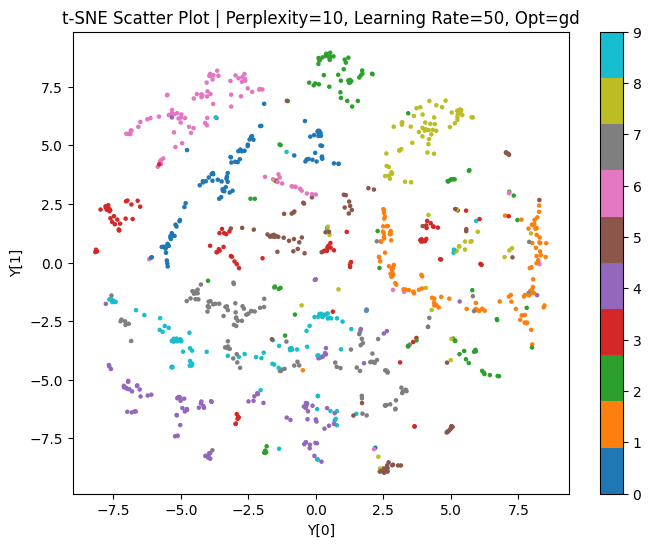

Starting tsne
Iteration 0, Cost: 4.760194778442383
Iteration 10, Cost: 4.760194778442383
Iteration 20, Cost: 4.760190963745117
Iteration 30, Cost: 4.760072708129883
Iteration 40, Cost: 4.75676965713501
Iteration 50, Cost: 4.703126907348633
Iteration 60, Cost: 4.4648919105529785
Iteration 70, Cost: 4.139920234680176
Iteration 80, Cost: 3.888878583908081
Iteration 90, Cost: 3.701533079147339
Iteration 100, Cost: 3.5534543991088867
Iteration 110, Cost: 3.4311318397521973
Iteration 120, Cost: 3.3269195556640625
Iteration 130, Cost: 3.236171245574951
Iteration 140, Cost: 3.1559016704559326
Iteration 150, Cost: 3.083955764770508
Iteration 160, Cost: 3.0186619758605957
Iteration 170, Cost: 2.9587721824645996
Iteration 180, Cost: 2.903444528579712
Iteration 190, Cost: 2.85215425491333
Iteration 200, Cost: 2.8045196533203125
Iteration 210, Cost: 2.760162353515625
Iteration 220, Cost: 2.7186875343322754
Iteration 230, Cost: 2.6797263622283936
Iteration 240, Cost: 2.6429808139801025
Iteration 250

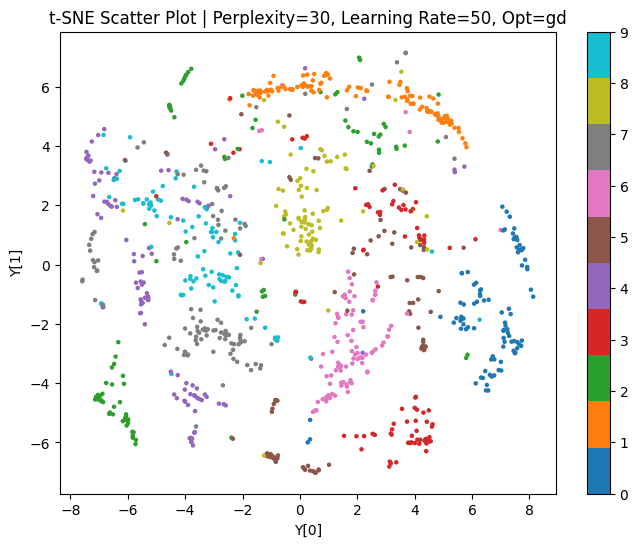

Starting tsne
Iteration 0, Cost: 4.193114280700684
Iteration 10, Cost: 4.193114280700684
Iteration 20, Cost: 4.193110942840576
Iteration 30, Cost: 4.193049430847168
Iteration 40, Cost: 4.191469669342041
Iteration 50, Cost: 4.16113805770874
Iteration 60, Cost: 3.9726696014404297
Iteration 70, Cost: 3.663543939590454
Iteration 80, Cost: 3.4132351875305176
Iteration 90, Cost: 3.2270610332489014
Iteration 100, Cost: 3.082139015197754
Iteration 110, Cost: 2.964399576187134
Iteration 120, Cost: 2.865872383117676
Iteration 130, Cost: 2.7816569805145264
Iteration 140, Cost: 2.708458662033081
Iteration 150, Cost: 2.643925905227661
Iteration 160, Cost: 2.5862998962402344
Iteration 170, Cost: 2.534243583679199
Iteration 180, Cost: 2.4867472648620605
Iteration 190, Cost: 2.4430670738220215
Iteration 200, Cost: 2.4026808738708496
Iteration 210, Cost: 2.3651998043060303
Iteration 220, Cost: 2.330286741256714
Iteration 230, Cost: 2.2976396083831787
Iteration 240, Cost: 2.2669942378997803
Iteration 25

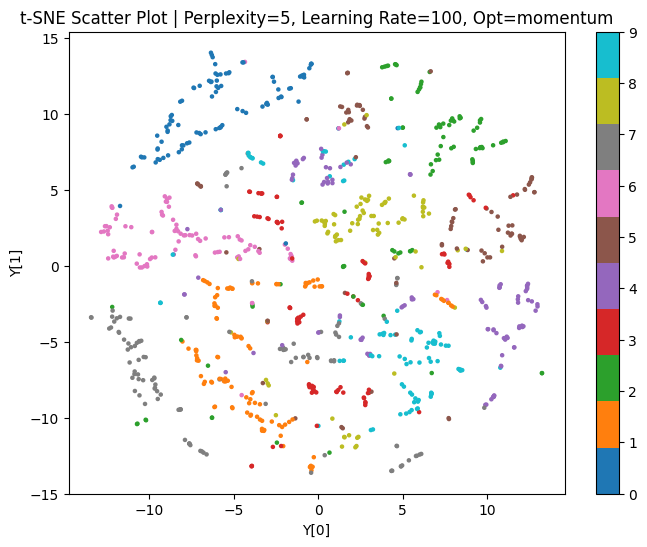

Starting tsne
Iteration 0, Cost: 5.155115127563477
Iteration 10, Cost: 5.155111312866211
Iteration 20, Cost: 5.153680801391602
Iteration 30, Cost: 4.940271377563477
Iteration 40, Cost: 4.3140435218811035
Iteration 50, Cost: 3.9422929286956787
Iteration 60, Cost: 3.6929433345794678
Iteration 70, Cost: 3.5059590339660645
Iteration 80, Cost: 3.356383800506592
Iteration 90, Cost: 3.2318367958068848
Iteration 100, Cost: 3.1253952980041504
Iteration 110, Cost: 3.0325121879577637
Iteration 120, Cost: 2.9502480030059814
Iteration 130, Cost: 2.8765792846679688
Iteration 140, Cost: 2.809988498687744
Iteration 150, Cost: 2.7493488788604736
Iteration 160, Cost: 2.693737030029297
Iteration 170, Cost: 2.6423873901367188
Iteration 180, Cost: 2.5946967601776123
Iteration 190, Cost: 2.55026912689209
Iteration 200, Cost: 2.5087432861328125
Iteration 210, Cost: 2.4697418212890625
Iteration 220, Cost: 2.432955026626587
Iteration 230, Cost: 2.3981385231018066
Iteration 240, Cost: 2.365102767944336
Iteratio

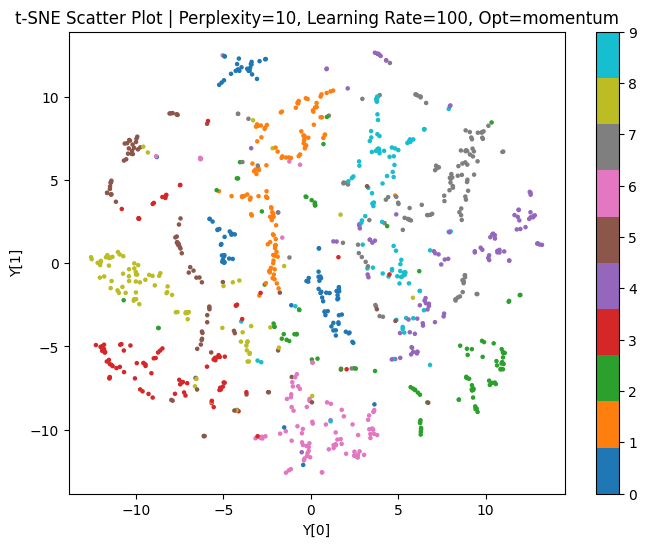

Starting tsne
Iteration 0, Cost: 4.805715560913086
Iteration 10, Cost: 4.805713176727295
Iteration 20, Cost: 4.804649829864502
Iteration 30, Cost: 4.649015426635742
Iteration 40, Cost: 4.06553840637207
Iteration 50, Cost: 3.6896767616271973
Iteration 60, Cost: 3.4423298835754395
Iteration 70, Cost: 3.2586119174957275
Iteration 80, Cost: 3.1137197017669678
Iteration 90, Cost: 2.994267463684082
Iteration 100, Cost: 2.8923287391662598
Iteration 110, Cost: 2.8034117221832275
Iteration 120, Cost: 2.7248778343200684
Iteration 130, Cost: 2.654975414276123
Iteration 140, Cost: 2.591974973678589
Iteration 150, Cost: 2.534780263900757
Iteration 160, Cost: 2.4827582836151123
Iteration 170, Cost: 2.4351608753204346
Iteration 180, Cost: 2.3912570476531982
Iteration 190, Cost: 2.3504910469055176
Iteration 200, Cost: 2.3124542236328125
Iteration 210, Cost: 2.2768213748931885
Iteration 220, Cost: 2.2433271408081055
Iteration 230, Cost: 2.211756706237793
Iteration 240, Cost: 2.1819210052490234
Iteratio

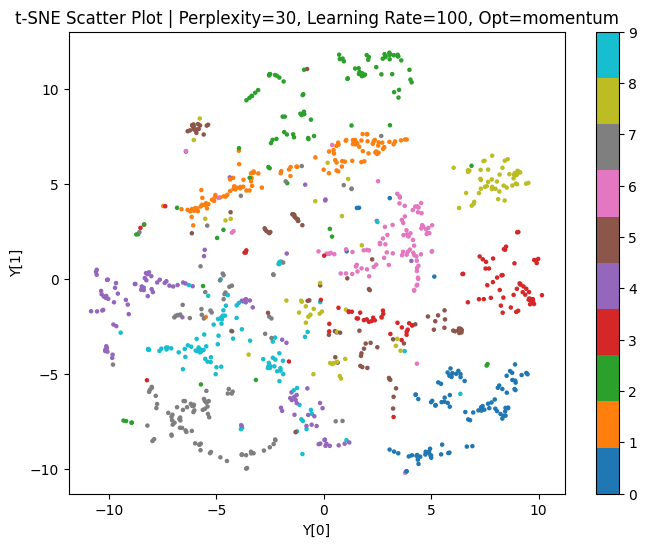

Starting tsne
Iteration 0, Cost: 4.244128227233887
Iteration 10, Cost: 4.244126319885254
Iteration 20, Cost: 4.243279933929443
Iteration 30, Cost: 4.115267276763916
Iteration 40, Cost: 3.5697734355926514
Iteration 50, Cost: 3.187757730484009
Iteration 60, Cost: 2.9495227336883545
Iteration 70, Cost: 2.7783656120300293
Iteration 80, Cost: 2.6458253860473633
Iteration 90, Cost: 2.538275718688965
Iteration 100, Cost: 2.448662519454956
Iteration 110, Cost: 2.3722293376922607
Iteration 120, Cost: 2.305727243423462
Iteration 130, Cost: 2.246896266937256
Iteration 140, Cost: 2.1942520141601562
Iteration 150, Cost: 2.1466963291168213
Iteration 160, Cost: 2.1033742427825928
Iteration 170, Cost: 2.06366229057312
Iteration 180, Cost: 2.0270943641662598
Iteration 190, Cost: 1.9932671785354614
Iteration 200, Cost: 1.961824655532837
Iteration 210, Cost: 1.932471752166748
Iteration 220, Cost: 1.904966115951538
Iteration 230, Cost: 1.8791048526763916
Iteration 240, Cost: 1.8547124862670898
Iteration 2

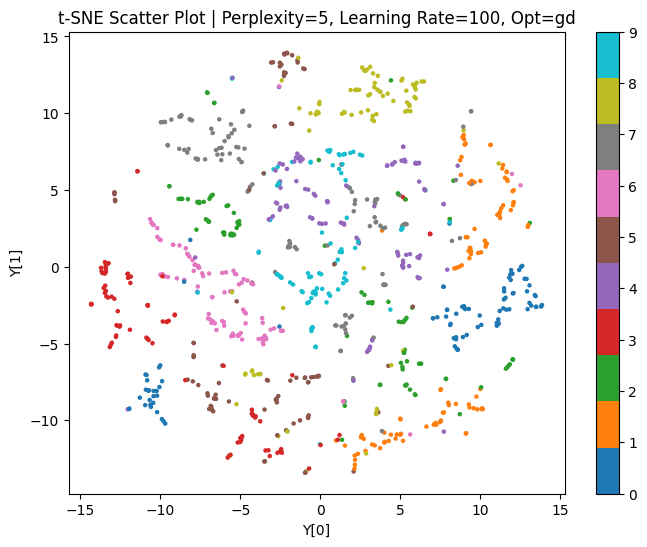

Starting tsne
Iteration 0, Cost: 5.143836498260498
Iteration 10, Cost: 5.143833637237549
Iteration 20, Cost: 5.142297744750977
Iteration 30, Cost: 4.918341159820557
Iteration 40, Cost: 4.285975933074951
Iteration 50, Cost: 3.914710283279419
Iteration 60, Cost: 3.6663689613342285
Iteration 70, Cost: 3.4803671836853027
Iteration 80, Cost: 3.3315954208374023
Iteration 90, Cost: 3.207731246948242
Iteration 100, Cost: 3.101886034011841
Iteration 110, Cost: 3.0096328258514404
Iteration 120, Cost: 2.9279606342315674
Iteration 130, Cost: 2.8549067974090576
Iteration 140, Cost: 2.7891435623168945
Iteration 150, Cost: 2.729438543319702
Iteration 160, Cost: 2.6746888160705566
Iteration 170, Cost: 2.6241021156311035
Iteration 180, Cost: 2.577169895172119
Iteration 190, Cost: 2.533444404602051
Iteration 200, Cost: 2.492481231689453
Iteration 210, Cost: 2.4539713859558105
Iteration 220, Cost: 2.417693853378296
Iteration 230, Cost: 2.383448600769043
Iteration 240, Cost: 2.3510525226593018
Iteration 2

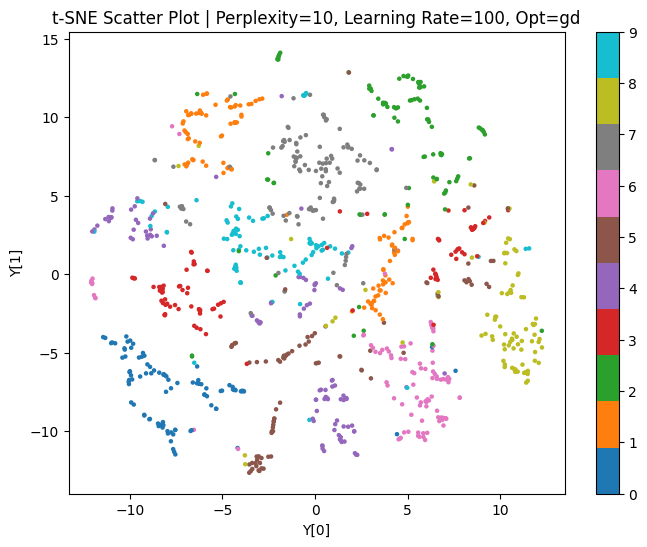

Starting tsne
Iteration 0, Cost: 4.7746901512146
Iteration 10, Cost: 4.77468729019165
Iteration 20, Cost: 4.773578643798828
Iteration 30, Cost: 4.595681667327881
Iteration 40, Cost: 3.9838972091674805
Iteration 50, Cost: 3.6039960384368896
Iteration 60, Cost: 3.3584983348846436
Iteration 70, Cost: 3.177515745162964
Iteration 80, Cost: 3.034999132156372
Iteration 90, Cost: 2.917695999145508
Iteration 100, Cost: 2.8177523612976074
Iteration 110, Cost: 2.730940103530884
Iteration 120, Cost: 2.654560089111328
Iteration 130, Cost: 2.586489200592041
Iteration 140, Cost: 2.5252695083618164
Iteration 150, Cost: 2.469780206680298
Iteration 160, Cost: 2.419140338897705
Iteration 170, Cost: 2.3726229667663574
Iteration 180, Cost: 2.3295843601226807
Iteration 190, Cost: 2.289463996887207
Iteration 200, Cost: 2.2519404888153076
Iteration 210, Cost: 2.216841459274292
Iteration 220, Cost: 2.183931350708008
Iteration 230, Cost: 2.1529605388641357
Iteration 240, Cost: 2.123704433441162
Iteration 250, C

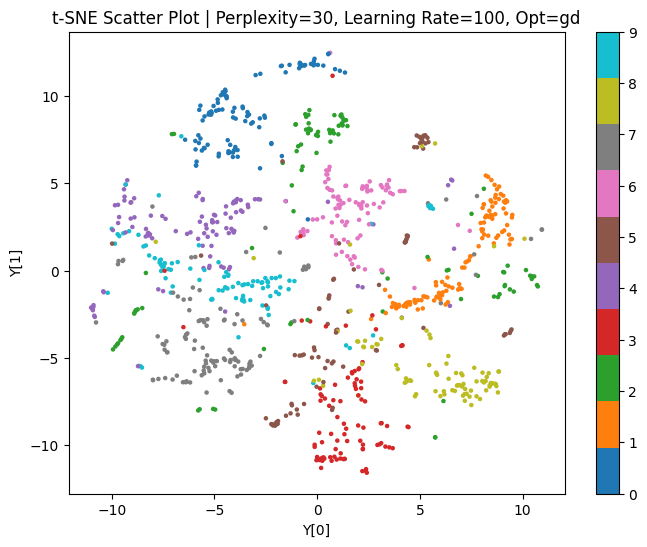

Starting tsne
Iteration 0, Cost: 4.173112869262695
Iteration 10, Cost: 4.173111438751221
Iteration 20, Cost: 4.1724700927734375
Iteration 30, Cost: 4.066649913787842
Iteration 40, Cost: 3.5609207153320312
Iteration 50, Cost: 3.184662342071533
Iteration 60, Cost: 2.9512689113616943
Iteration 70, Cost: 2.783296585083008
Iteration 80, Cost: 2.652801752090454
Iteration 90, Cost: 2.546595573425293
Iteration 100, Cost: 2.4572594165802
Iteration 110, Cost: 2.3803815841674805
Iteration 120, Cost: 2.313098430633545
Iteration 130, Cost: 2.2536463737487793
Iteration 140, Cost: 2.2005255222320557
Iteration 150, Cost: 2.152459144592285
Iteration 160, Cost: 2.108644485473633
Iteration 170, Cost: 2.068624496459961
Iteration 180, Cost: 2.0318713188171387
Iteration 190, Cost: 1.9978716373443604
Iteration 200, Cost: 1.9662468433380127
Iteration 210, Cost: 1.936723232269287
Iteration 220, Cost: 1.9090662002563477
Iteration 230, Cost: 1.8830318450927734
Iteration 240, Cost: 1.8583941459655762
Iteration 25

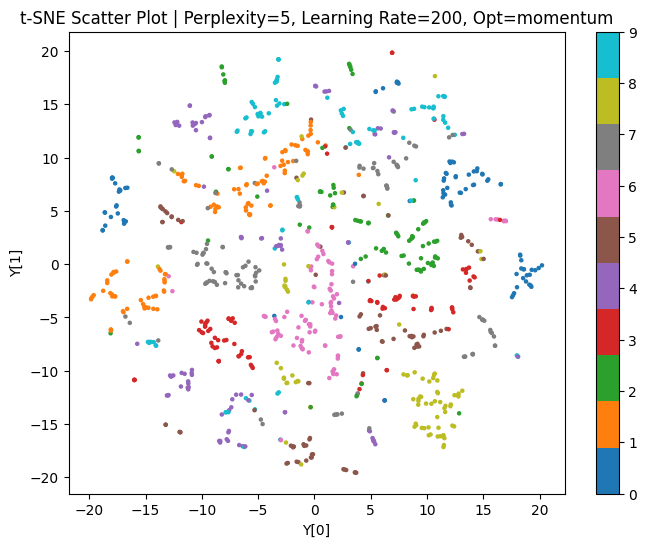

Starting tsne
Iteration 0, Cost: 5.177304267883301
Iteration 10, Cost: 5.1769328117370605
Iteration 20, Cost: 4.539129734039307
Iteration 30, Cost: 3.7982029914855957
Iteration 40, Cost: 3.4312918186187744
Iteration 50, Cost: 3.1829214096069336
Iteration 60, Cost: 2.997450351715088
Iteration 70, Cost: 2.851275682449341
Iteration 80, Cost: 2.7313506603240967
Iteration 90, Cost: 2.629617691040039
Iteration 100, Cost: 2.541459560394287
Iteration 110, Cost: 2.4639382362365723
Iteration 120, Cost: 2.394838333129883
Iteration 130, Cost: 2.3324811458587646
Iteration 140, Cost: 2.2757840156555176
Iteration 150, Cost: 2.223936080932617
Iteration 160, Cost: 2.176034688949585
Iteration 170, Cost: 2.131392240524292
Iteration 180, Cost: 2.0902504920959473
Iteration 190, Cost: 2.052018165588379
Iteration 200, Cost: 2.016247034072876
Iteration 210, Cost: 1.9826688766479492
Iteration 220, Cost: 1.9510672092437744
Iteration 230, Cost: 1.9212391376495361
Iteration 240, Cost: 1.8930234909057617
Iteration

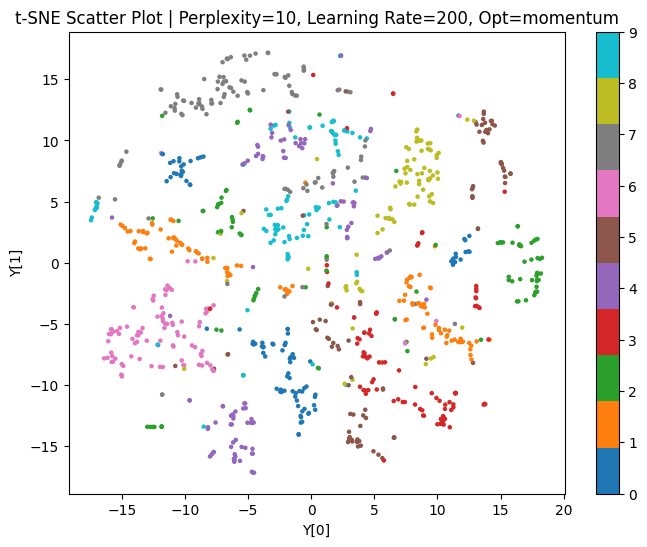

Starting tsne
Iteration 0, Cost: 4.750687599182129
Iteration 10, Cost: 4.750406742095947
Iteration 20, Cost: 4.197963714599609
Iteration 30, Cost: 3.4472906589508057
Iteration 40, Cost: 3.0900826454162598
Iteration 50, Cost: 2.859560489654541
Iteration 60, Cost: 2.690472364425659
Iteration 70, Cost: 2.5577564239501953
Iteration 80, Cost: 2.4493188858032227
Iteration 90, Cost: 2.357834815979004
Iteration 100, Cost: 2.2788987159729004
Iteration 110, Cost: 2.2100367546081543
Iteration 120, Cost: 2.1490955352783203
Iteration 130, Cost: 2.094412088394165
Iteration 140, Cost: 2.0449118614196777
Iteration 150, Cost: 1.9997828006744385
Iteration 160, Cost: 1.9583784341812134
Iteration 170, Cost: 1.920173168182373
Iteration 180, Cost: 1.8847495317459106
Iteration 190, Cost: 1.8517953157424927
Iteration 200, Cost: 1.821030855178833
Iteration 210, Cost: 1.7921879291534424
Iteration 220, Cost: 1.7650413513183594
Iteration 230, Cost: 1.7394118309020996
Iteration 240, Cost: 1.7151509523391724
Iterat

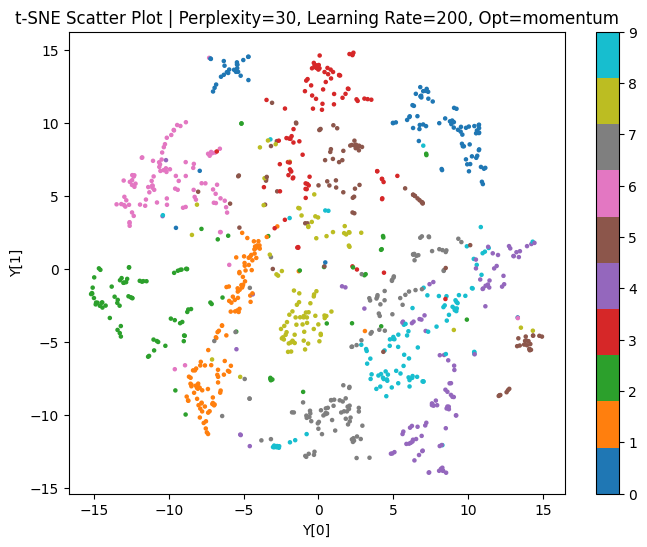

Starting tsne
Iteration 0, Cost: 4.151707172393799
Iteration 10, Cost: 4.151558876037598
Iteration 20, Cost: 3.7547435760498047
Iteration 30, Cost: 2.977344036102295
Iteration 40, Cost: 2.6305313110351562
Iteration 50, Cost: 2.416738510131836
Iteration 60, Cost: 2.2662253379821777
Iteration 70, Cost: 2.150862455368042
Iteration 80, Cost: 2.0576565265655518
Iteration 90, Cost: 1.9799714088439941
Iteration 100, Cost: 1.9137825965881348
Iteration 110, Cost: 1.8563001155853271
Iteration 120, Cost: 1.8055641651153564
Iteration 130, Cost: 1.7601962089538574
Iteration 140, Cost: 1.7192504405975342
Iteration 150, Cost: 1.6820544004440308
Iteration 160, Cost: 1.6480674743652344
Iteration 170, Cost: 1.6168272495269775
Iteration 180, Cost: 1.587951898574829
Iteration 190, Cost: 1.561133861541748
Iteration 200, Cost: 1.536121129989624
Iteration 210, Cost: 1.5127043724060059
Iteration 220, Cost: 1.4907071590423584
Iteration 230, Cost: 1.469980001449585
Iteration 240, Cost: 1.4503966569900513
Iterat

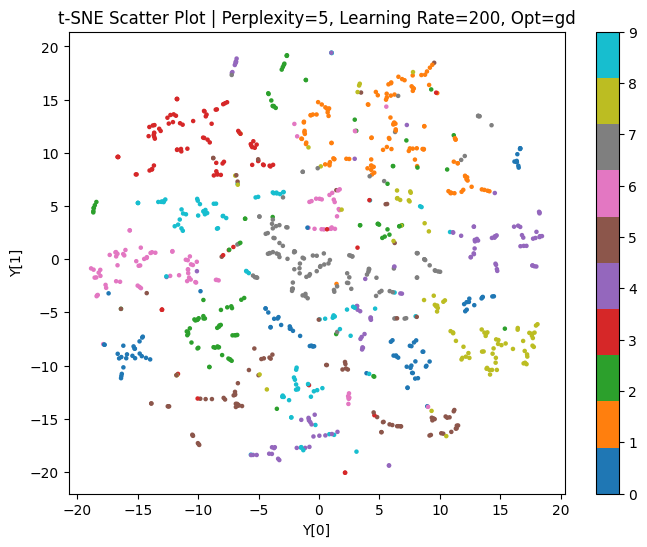

Starting tsne
Iteration 0, Cost: 5.170337677001953
Iteration 10, Cost: 5.16999626159668
Iteration 20, Cost: 4.497387886047363
Iteration 30, Cost: 3.7514519691467285
Iteration 40, Cost: 3.382420301437378
Iteration 50, Cost: 3.1381115913391113
Iteration 60, Cost: 2.9560256004333496
Iteration 70, Cost: 2.812028169631958
Iteration 80, Cost: 2.6936962604522705
Iteration 90, Cost: 2.5935072898864746
Iteration 100, Cost: 2.506673812866211
Iteration 110, Cost: 2.430137872695923
Iteration 120, Cost: 2.3619325160980225
Iteration 130, Cost: 2.3005471229553223
Iteration 140, Cost: 2.2448549270629883
Iteration 150, Cost: 2.1939756870269775
Iteration 160, Cost: 2.147200107574463
Iteration 170, Cost: 2.103952407836914
Iteration 180, Cost: 2.0637683868408203
Iteration 190, Cost: 2.0262651443481445
Iteration 200, Cost: 1.9911288022994995
Iteration 210, Cost: 1.9581016302108765
Iteration 220, Cost: 1.9269802570343018
Iteration 230, Cost: 1.8975944519042969
Iteration 240, Cost: 1.8697803020477295
Iterati

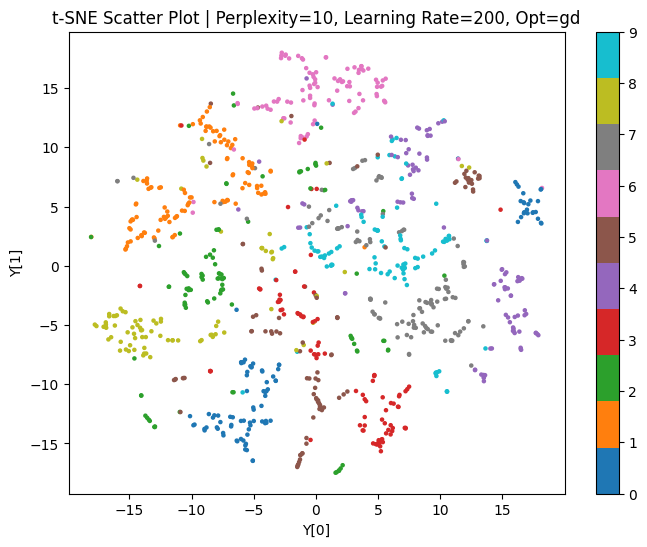

Starting tsne
Iteration 0, Cost: 4.771829128265381
Iteration 10, Cost: 4.771572113037109
Iteration 20, Cost: 4.1837944984436035
Iteration 30, Cost: 3.421961784362793
Iteration 40, Cost: 3.0668649673461914
Iteration 50, Cost: 2.834878444671631
Iteration 60, Cost: 2.663586378097534
Iteration 70, Cost: 2.5296339988708496
Iteration 80, Cost: 2.42025089263916
Iteration 90, Cost: 2.3279612064361572
Iteration 100, Cost: 2.248074531555176
Iteration 110, Cost: 2.1781868934631348
Iteration 120, Cost: 2.116393566131592
Iteration 130, Cost: 2.061070203781128
Iteration 140, Cost: 2.010922431945801
Iteration 150, Cost: 1.965000867843628
Iteration 160, Cost: 1.9227524995803833
Iteration 170, Cost: 1.8837987184524536
Iteration 180, Cost: 1.8477346897125244
Iteration 190, Cost: 1.814185380935669
Iteration 200, Cost: 1.7828367948532104
Iteration 210, Cost: 1.7534176111221313
Iteration 220, Cost: 1.7256860733032227
Iteration 230, Cost: 1.6994684934616089
Iteration 240, Cost: 1.6746594905853271
Iteration 

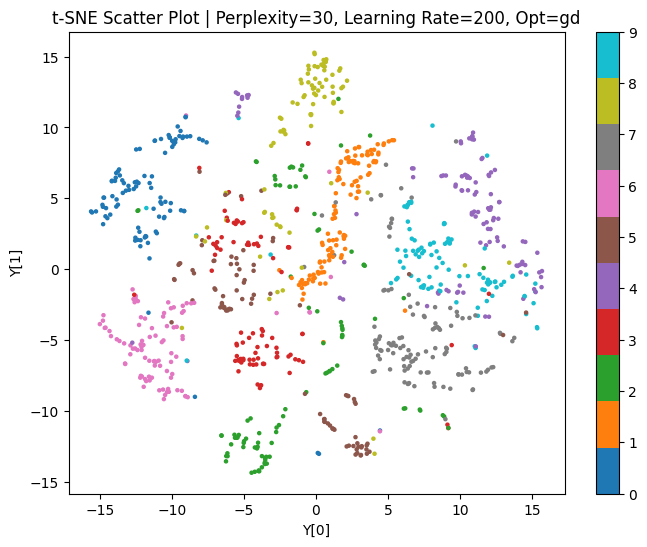

Starting tsne
Iteration 0, Cost: 4.257737159729004
Iteration 10, Cost: 4.257519721984863
Iteration 20, Cost: 3.8060131072998047
Iteration 30, Cost: 3.0713858604431152
Iteration 40, Cost: 2.731196641921997
Iteration 50, Cost: 2.514565944671631
Iteration 60, Cost: 2.3588695526123047
Iteration 70, Cost: 2.239034652709961
Iteration 80, Cost: 2.1423113346099854
Iteration 90, Cost: 2.0616865158081055
Iteration 100, Cost: 1.9930052757263184
Iteration 110, Cost: 1.9334834814071655
Iteration 120, Cost: 1.8810083866119385
Iteration 130, Cost: 1.8341495990753174
Iteration 140, Cost: 1.7918381690979004
Iteration 150, Cost: 1.7532206773757935
Iteration 160, Cost: 1.7176283597946167
Iteration 170, Cost: 1.684749960899353
Iteration 180, Cost: 1.6545207500457764
Iteration 190, Cost: 1.626528024673462
Iteration 200, Cost: 1.6004775762557983
Iteration 210, Cost: 1.5761021375656128
Iteration 220, Cost: 1.5531951189041138
Iteration 230, Cost: 1.5315933227539062
Iteration 240, Cost: 1.5111594200134277
Iter

In [10]:
# Define the parameter grid
param_grid = {
    'perplexity': [5, 10, 30],
    'learning_rate': [50, 100, 200],
    'opt': ['momentum', 'gd']
}

# Perform bootstrap validation
best_params, results_array = bootstrap_val_tsne(X_tr, y_tr, param_grid, CustomTSNE, num_bootstraps=5, n_iter=500)

##### boostraps plots

    perplexity  learning_rate       opt      cost
14        30.0          200.0  momentum  1.160102
17        30.0          200.0        gd  1.162534
16        10.0          200.0        gd  1.337569
13        10.0          200.0  momentum  1.357078
8         30.0          100.0  momentum  1.421119
11        30.0          100.0        gd  1.421854
15         5.0          200.0        gd  1.500103
12         5.0          200.0  momentum  1.509547
7         10.0          100.0  momentum  1.666659
10        10.0          100.0        gd  1.669930
2         30.0           50.0  momentum  1.749143
5         30.0           50.0        gd  1.764514
9          5.0          100.0        gd  1.860885
6          5.0          100.0  momentum  1.881618
1         10.0           50.0  momentum  2.042087
4         10.0           50.0        gd  2.067608
0          5.0           50.0  momentum  2.325996
3          5.0           50.0        gd  2.335827


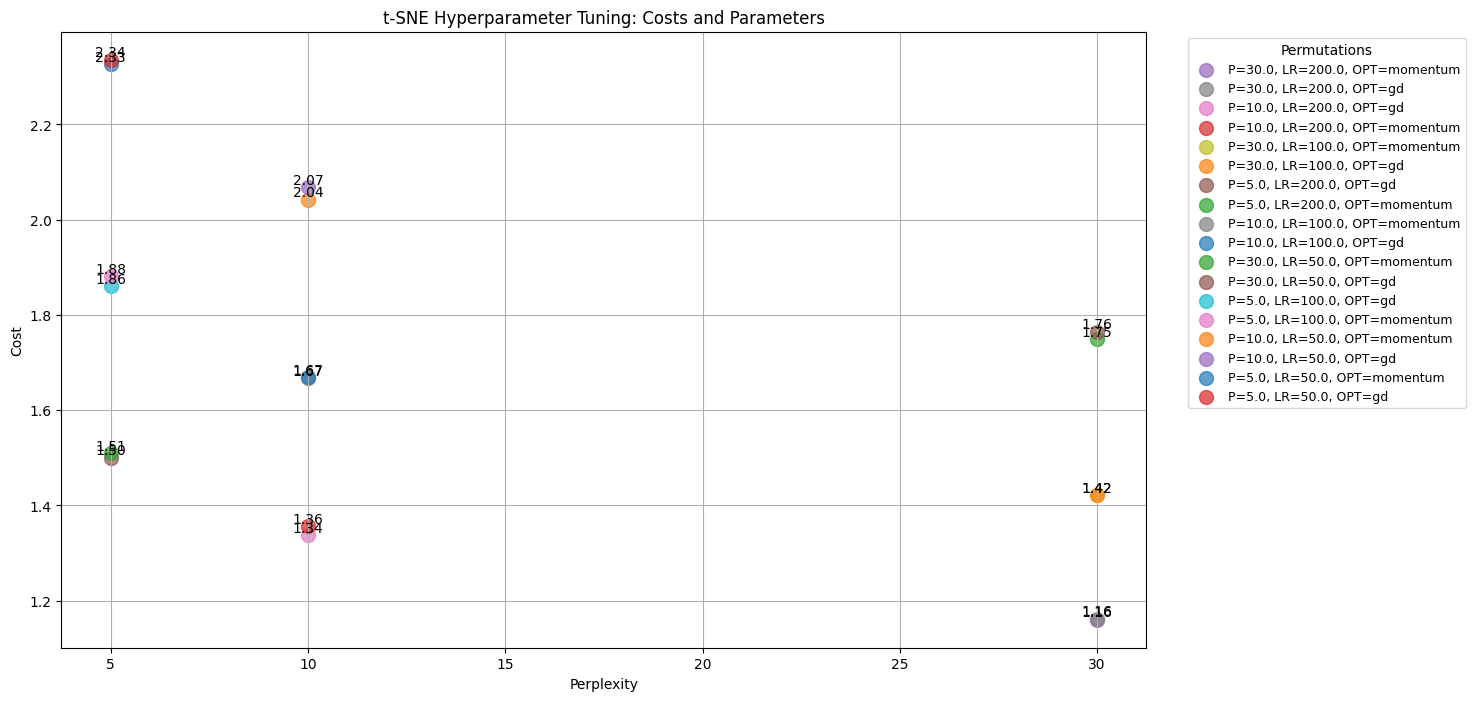

In [11]:
# Plot the results
plot_all_combinations(results_array)

#### 2nd bootstrap
**Perplexity**: 30, 50, 100

**Learning Rate**: 200

**Optimizer**: Momentum, GD

Testing perplexity=30, learning_rate=200, opt=momentum, n_iter=500
Starting tsne
Iteration 0, Cost: 3.3980605602264404
Iteration 10, Cost: 3.398033380508423
Iteration 20, Cost: 3.147069215774536
Iteration 30, Cost: 2.402824878692627
Iteration 40, Cost: 2.11724853515625
Iteration 50, Cost: 1.9477159976959229
Iteration 60, Cost: 1.8301222324371338
Iteration 70, Cost: 1.7425353527069092
Iteration 80, Cost: 1.6735199689865112
Iteration 90, Cost: 1.6168655157089233
Iteration 100, Cost: 1.5682164430618286
Iteration 110, Cost: 1.5270839929580688
Iteration 120, Cost: 1.4911353588104248
Iteration 130, Cost: 1.4592785835266113
Iteration 140, Cost: 1.4309964179992676
Iteration 150, Cost: 1.4056775569915771
Iteration 160, Cost: 1.3828599452972412
Iteration 170, Cost: 1.362252116203308
Iteration 180, Cost: 1.3434945344924927
Iteration 190, Cost: 1.3262773752212524
Iteration 200, Cost: 1.3103666305541992
Iteration 210, Cost: 1.2955858707427979
Iteration 220, Cost: 1.2818236351013184
Iteration 230, C

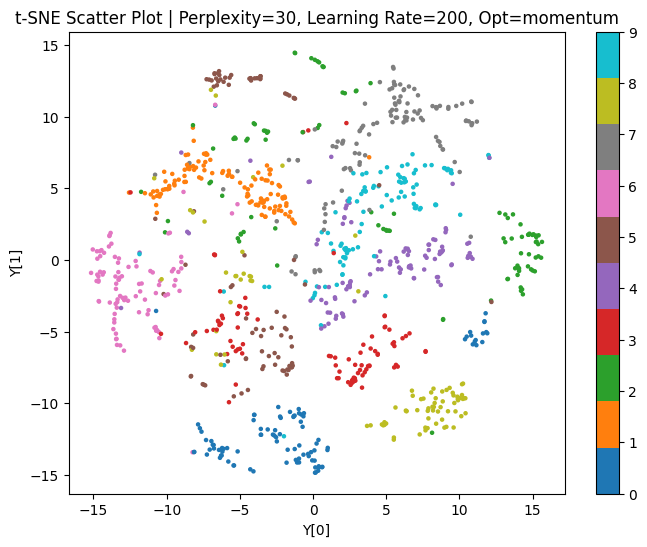

Starting tsne
Iteration 0, Cost: 4.186872959136963
Iteration 10, Cost: 4.1867265701293945
Iteration 20, Cost: 3.7690396308898926
Iteration 30, Cost: 3.0137290954589844
Iteration 40, Cost: 2.6758060455322266
Iteration 50, Cost: 2.4635252952575684
Iteration 60, Cost: 2.311164379119873
Iteration 70, Cost: 2.194685459136963
Iteration 80, Cost: 2.1012415885925293
Iteration 90, Cost: 2.02362060546875
Iteration 100, Cost: 1.957608699798584
Iteration 110, Cost: 1.9003275632858276
Iteration 120, Cost: 1.8498005867004395
Iteration 130, Cost: 1.8046058416366577
Iteration 140, Cost: 1.7637629508972168
Iteration 150, Cost: 1.7266429662704468
Iteration 160, Cost: 1.6927359104156494
Iteration 170, Cost: 1.6615784168243408
Iteration 180, Cost: 1.632787823677063
Iteration 190, Cost: 1.6060500144958496
Iteration 200, Cost: 1.5811007022857666
Iteration 210, Cost: 1.557723879814148
Iteration 220, Cost: 1.5357539653778076
Iteration 230, Cost: 1.5150532722473145
Iteration 240, Cost: 1.4954942464828491
Itera

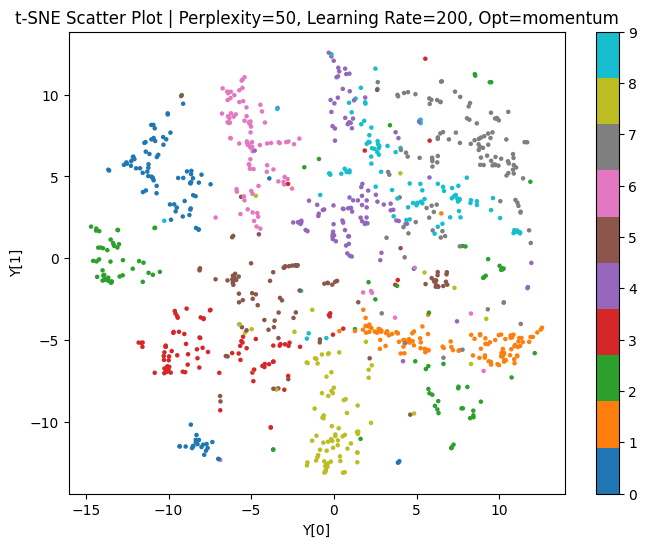

Starting tsne
Iteration 0, Cost: 4.10340690612793
Iteration 10, Cost: 4.103170394897461
Iteration 20, Cost: 3.6872150897979736
Iteration 30, Cost: 2.953503370285034
Iteration 40, Cost: 2.624504327774048
Iteration 50, Cost: 2.417884349822998
Iteration 60, Cost: 2.2693824768066406
Iteration 70, Cost: 2.1553194522857666
Iteration 80, Cost: 2.0639240741729736
Iteration 90, Cost: 1.9880471229553223
Iteration 100, Cost: 1.9229459762573242
Iteration 110, Cost: 1.8654186725616455
Iteration 120, Cost: 1.8143880367279053
Iteration 130, Cost: 1.7693791389465332
Iteration 140, Cost: 1.7285770177841187
Iteration 150, Cost: 1.690666675567627
Iteration 160, Cost: 1.6566369533538818
Iteration 170, Cost: 1.6257493495941162
Iteration 180, Cost: 1.597319483757019
Iteration 190, Cost: 1.570924997329712
Iteration 200, Cost: 1.5463019609451294
Iteration 210, Cost: 1.5232186317443848
Iteration 220, Cost: 1.5014927387237549
Iteration 230, Cost: 1.480999231338501
Iteration 240, Cost: 1.4616358280181885
Iterati

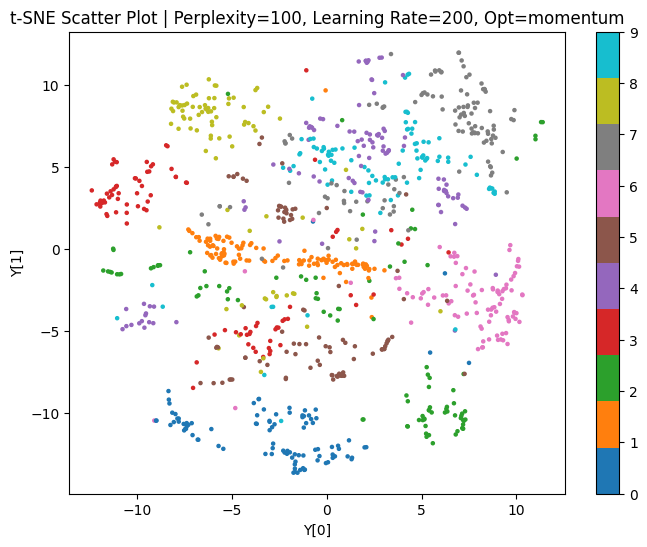

Starting tsne
Iteration 0, Cost: 3.8658947944641113
Iteration 10, Cost: 3.8657355308532715
Iteration 20, Cost: 3.5006837844848633
Iteration 30, Cost: 2.792166233062744
Iteration 40, Cost: 2.4877243041992188
Iteration 50, Cost: 2.3025684356689453
Iteration 60, Cost: 2.1700899600982666
Iteration 70, Cost: 2.0672428607940674
Iteration 80, Cost: 1.9840444326400757
Iteration 90, Cost: 1.9147511720657349
Iteration 100, Cost: 1.8554039001464844
Iteration 110, Cost: 1.8035351037979126
Iteration 120, Cost: 1.757749080657959
Iteration 130, Cost: 1.717077374458313
Iteration 140, Cost: 1.680428147315979
Iteration 150, Cost: 1.6471714973449707
Iteration 160, Cost: 1.6167458295822144
Iteration 170, Cost: 1.5887155532836914
Iteration 180, Cost: 1.5627400875091553
Iteration 190, Cost: 1.5385470390319824
Iteration 200, Cost: 1.5159037113189697
Iteration 210, Cost: 1.494616985321045
Iteration 220, Cost: 1.4745566844940186
Iteration 230, Cost: 1.4556083679199219
Iteration 240, Cost: 1.4376784563064575
It

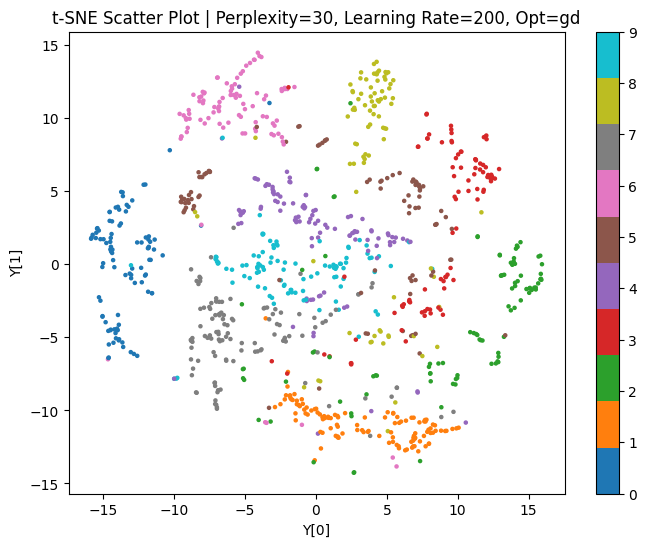

Starting tsne
Iteration 0, Cost: 4.130952835083008
Iteration 10, Cost: 4.130784034729004
Iteration 20, Cost: 3.656593084335327
Iteration 30, Cost: 2.9233551025390625
Iteration 40, Cost: 2.598738431930542
Iteration 50, Cost: 2.3929190635681152
Iteration 60, Cost: 2.24420166015625
Iteration 70, Cost: 2.1305809020996094
Iteration 80, Cost: 2.039731740951538
Iteration 90, Cost: 1.9639906883239746
Iteration 100, Cost: 1.8994507789611816
Iteration 110, Cost: 1.8432749509811401
Iteration 120, Cost: 1.7936491966247559
Iteration 130, Cost: 1.749375820159912
Iteration 140, Cost: 1.7095131874084473
Iteration 150, Cost: 1.6732752323150635
Iteration 160, Cost: 1.640077829360962
Iteration 170, Cost: 1.6094942092895508
Iteration 180, Cost: 1.5811678171157837
Iteration 190, Cost: 1.5548416376113892
Iteration 200, Cost: 1.5303025245666504
Iteration 210, Cost: 1.5073487758636475
Iteration 220, Cost: 1.485785961151123
Iteration 230, Cost: 1.4654515981674194
Iteration 240, Cost: 1.4462487697601318
Iterati

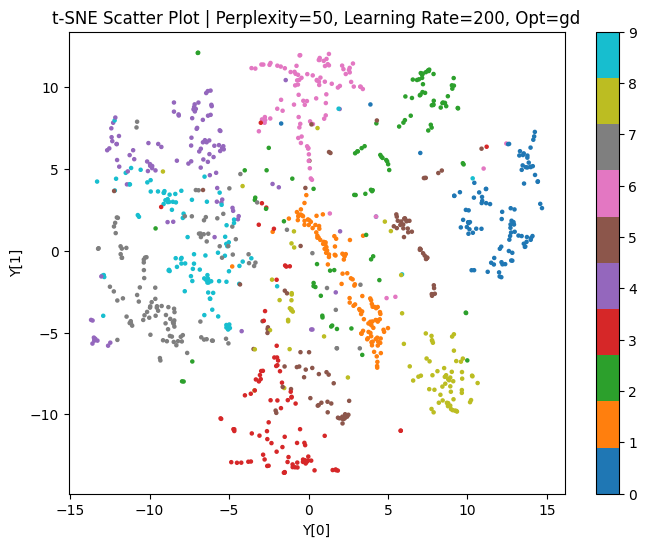

Starting tsne
Iteration 0, Cost: 4.102228164672852
Iteration 10, Cost: 4.1020588874816895
Iteration 20, Cost: 3.7099623680114746
Iteration 30, Cost: 2.980846405029297
Iteration 40, Cost: 2.656496524810791
Iteration 50, Cost: 2.451334238052368
Iteration 60, Cost: 2.303393840789795
Iteration 70, Cost: 2.1875076293945312
Iteration 80, Cost: 2.093698740005493
Iteration 90, Cost: 2.016698122024536
Iteration 100, Cost: 1.9514994621276855
Iteration 110, Cost: 1.894850730895996
Iteration 120, Cost: 1.8446943759918213
Iteration 130, Cost: 1.7997785806655884
Iteration 140, Cost: 1.7594491243362427
Iteration 150, Cost: 1.722917079925537
Iteration 160, Cost: 1.6894985437393188
Iteration 170, Cost: 1.6586869955062866
Iteration 180, Cost: 1.6301326751708984
Iteration 190, Cost: 1.6035960912704468
Iteration 200, Cost: 1.5788590908050537
Iteration 210, Cost: 1.555720329284668
Iteration 220, Cost: 1.534002423286438
Iteration 230, Cost: 1.5135531425476074
Iteration 240, Cost: 1.4942412376403809
Iteratio

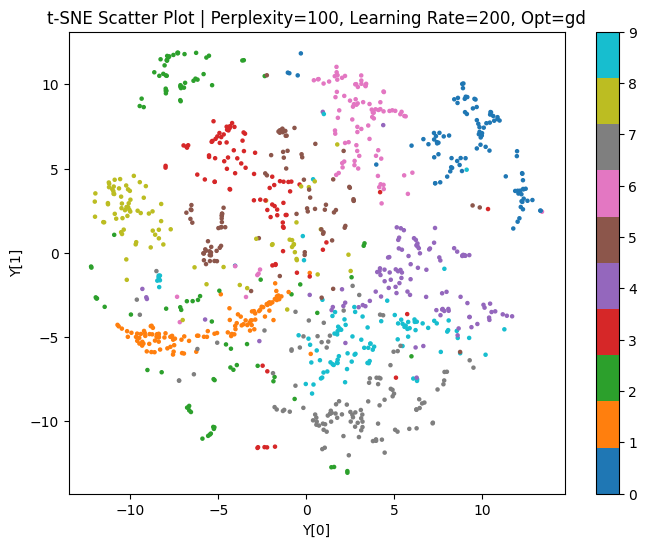

Starting tsne
Iteration 0, Cost: 3.8656997680664062
Iteration 10, Cost: 3.8655428886413574
Iteration 20, Cost: 3.508091926574707
Iteration 30, Cost: 2.798353910446167
Iteration 40, Cost: 2.483468532562256
Iteration 50, Cost: 2.2894020080566406
Iteration 60, Cost: 2.1524369716644287
Iteration 70, Cost: 2.048213005065918
Iteration 80, Cost: 1.964118242263794
Iteration 90, Cost: 1.8940722942352295
Iteration 100, Cost: 1.8343169689178467
Iteration 110, Cost: 1.7824231386184692
Iteration 120, Cost: 1.7366433143615723
Iteration 130, Cost: 1.6957123279571533
Iteration 140, Cost: 1.658790111541748
Iteration 150, Cost: 1.625274419784546
Iteration 160, Cost: 1.5946288108825684
Iteration 170, Cost: 1.5664178133010864
Iteration 180, Cost: 1.5402805805206299
Iteration 190, Cost: 1.5159220695495605
Iteration 200, Cost: 1.4931524991989136
Iteration 210, Cost: 1.4718077182769775
Iteration 220, Cost: 1.4517358541488647
Iteration 230, Cost: 1.4327895641326904
Iteration 240, Cost: 1.4148545265197754
Iter

In [12]:
# Define the parameter grid
param_grid = {
    'perplexity': [30, 50, 100],
    'learning_rate': [200],
    'opt': ['momentum', 'gd']
}

# Perform bootstrap validation
best_params, results_array = bootstrap_val_tsne(X_tr, y_tr, param_grid, CustomTSNE, num_bootstraps=5, n_iter=500)

   perplexity  learning_rate       opt      cost
5       100.0          200.0        gd  1.066361
2       100.0          200.0  momentum  1.084907
1        50.0          200.0  momentum  1.110537
4        50.0          200.0        gd  1.118298
3        30.0          200.0        gd  1.137885
0        30.0          200.0  momentum  1.178697


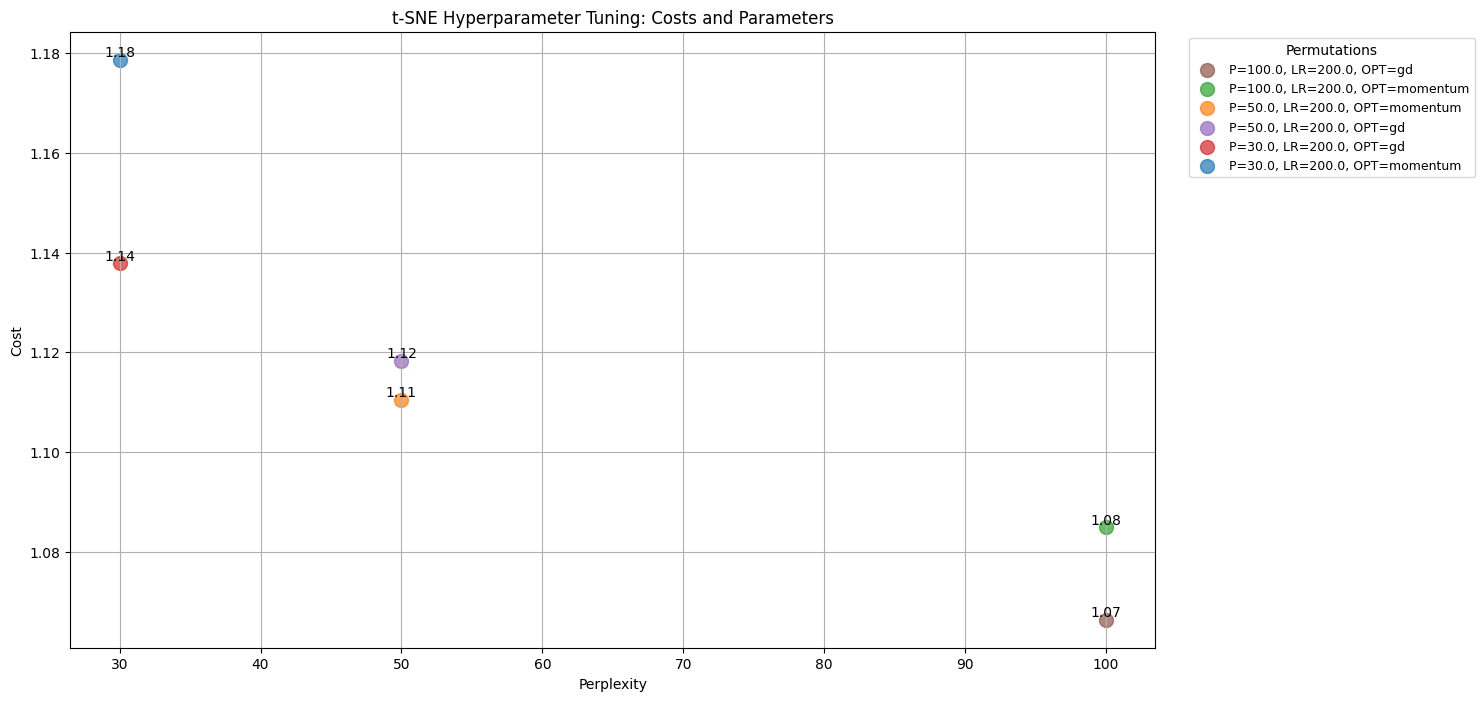

In [13]:
plot_all_combinations(results_array)

#### 3rd bootstrap

**Perplexity**: 30, 50, 100

**Learning Rate**: 200

**Optimizer**: Momentum, GD

Testing perplexity=100, learning_rate=200, opt=momentum, n_iter=1000
Starting tsne
Iteration 0, Cost: 2.6060407161712646
Iteration 10, Cost: 2.6060261726379395
Iteration 20, Cost: 2.5032196044921875
Iteration 30, Cost: 1.8287688493728638
Iteration 40, Cost: 1.5783207416534424
Iteration 50, Cost: 1.4432847499847412
Iteration 60, Cost: 1.3543000221252441
Iteration 70, Cost: 1.2898348569869995
Iteration 80, Cost: 1.239700436592102
Iteration 90, Cost: 1.1993266344070435
Iteration 100, Cost: 1.1666804552078247
Iteration 110, Cost: 1.1392476558685303
Iteration 120, Cost: 1.1155147552490234
Iteration 130, Cost: 1.094500184059143
Iteration 140, Cost: 1.076012372970581
Iteration 150, Cost: 1.059647798538208
Iteration 160, Cost: 1.0449720621109009
Iteration 170, Cost: 1.031686544418335
Iteration 180, Cost: 1.0195841789245605
Iteration 190, Cost: 1.008495569229126
Iteration 200, Cost: 0.9982720613479614
Iteration 210, Cost: 0.9888139367103577
Iteration 220, Cost: 0.9800409078598022
Iteration 230,

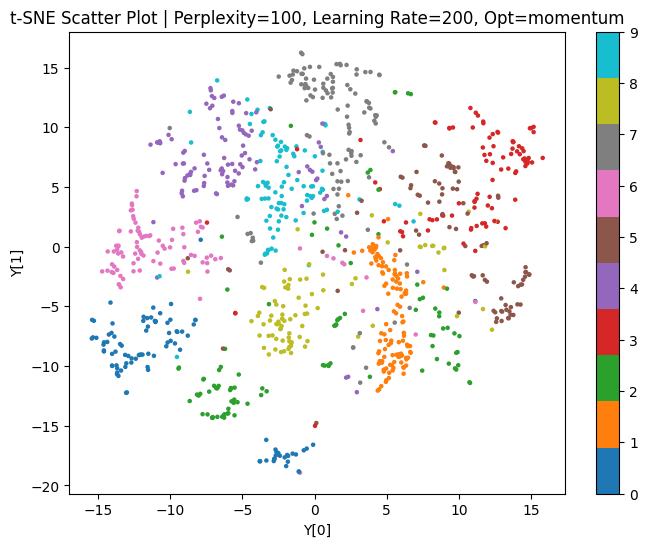

Starting tsne
Iteration 0, Cost: 3.934614658355713
Iteration 10, Cost: 3.934443950653076
Iteration 20, Cost: 3.5118846893310547
Iteration 30, Cost: 2.793689250946045
Iteration 40, Cost: 2.4866862297058105
Iteration 50, Cost: 2.2959771156311035
Iteration 60, Cost: 2.160313129425049
Iteration 70, Cost: 2.056220054626465
Iteration 80, Cost: 1.9724087715148926
Iteration 90, Cost: 1.902530312538147
Iteration 100, Cost: 1.8427379131317139
Iteration 110, Cost: 1.7906663417816162
Iteration 120, Cost: 1.7446520328521729
Iteration 130, Cost: 1.7034800052642822
Iteration 140, Cost: 1.6663792133331299
Iteration 150, Cost: 1.6326384544372559
Iteration 160, Cost: 1.6016885042190552
Iteration 170, Cost: 1.5731135606765747
Iteration 180, Cost: 1.5465871095657349
Iteration 190, Cost: 1.5218515396118164
Iteration 200, Cost: 1.4987633228302002
Iteration 210, Cost: 1.47713041305542
Iteration 220, Cost: 1.4567646980285645
Iteration 230, Cost: 1.4375402927398682
Iteration 240, Cost: 1.4193717241287231
Itera

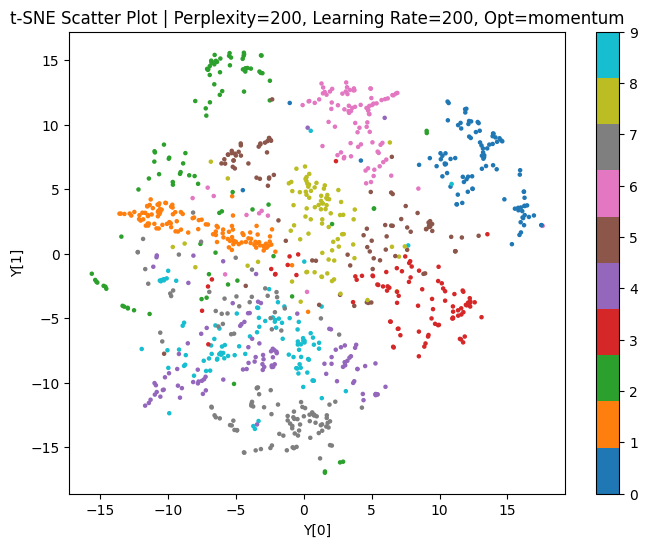

Starting tsne
Iteration 0, Cost: 3.7842164039611816
Iteration 10, Cost: 3.784048080444336
Iteration 20, Cost: 3.436347484588623
Iteration 30, Cost: 2.764671802520752
Iteration 40, Cost: 2.464937448501587
Iteration 50, Cost: 2.276926040649414
Iteration 60, Cost: 2.1415867805480957
Iteration 70, Cost: 2.037360668182373
Iteration 80, Cost: 1.9533408880233765
Iteration 90, Cost: 1.882987141609192
Iteration 100, Cost: 1.8227412700653076
Iteration 110, Cost: 1.7706049680709839
Iteration 120, Cost: 1.7247685194015503
Iteration 130, Cost: 1.6839137077331543
Iteration 140, Cost: 1.6471226215362549
Iteration 150, Cost: 1.613701581954956
Iteration 160, Cost: 1.5831221342086792
Iteration 170, Cost: 1.5549523830413818
Iteration 180, Cost: 1.5288512706756592
Iteration 190, Cost: 1.5045394897460938
Iteration 200, Cost: 1.4818115234375
Iteration 210, Cost: 1.4605313539505005
Iteration 220, Cost: 1.440559983253479
Iteration 230, Cost: 1.4217462539672852
Iteration 240, Cost: 1.403958797454834
Iteration 

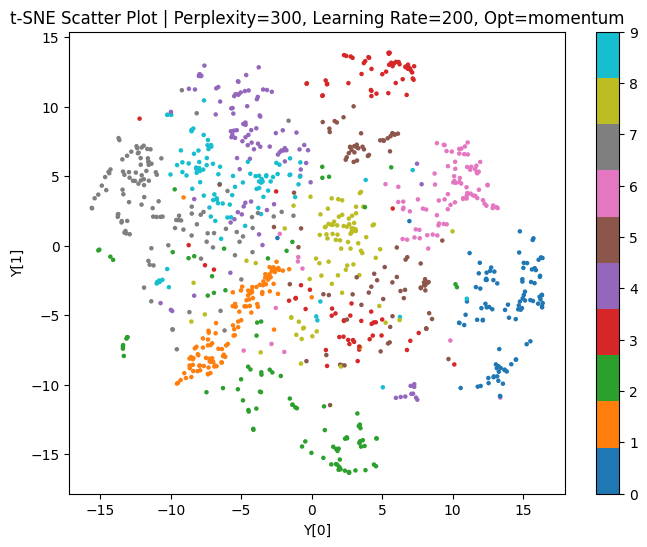

Starting tsne
Iteration 0, Cost: 3.826375961303711
Iteration 10, Cost: 3.826199769973755
Iteration 20, Cost: 3.4510393142700195
Iteration 30, Cost: 2.770820379257202
Iteration 40, Cost: 2.4663987159729004
Iteration 50, Cost: 2.2761387825012207
Iteration 60, Cost: 2.139942169189453
Iteration 70, Cost: 2.0346713066101074
Iteration 80, Cost: 1.9494738578796387
Iteration 90, Cost: 1.878821611404419
Iteration 100, Cost: 1.8189985752105713
Iteration 110, Cost: 1.767085313796997
Iteration 120, Cost: 1.7212144136428833
Iteration 130, Cost: 1.6801362037658691
Iteration 140, Cost: 1.6430141925811768
Iteration 150, Cost: 1.6093050241470337
Iteration 160, Cost: 1.5784919261932373
Iteration 170, Cost: 1.5501084327697754
Iteration 180, Cost: 1.5237934589385986
Iteration 190, Cost: 1.4992754459381104
Iteration 200, Cost: 1.4763458967208862
Iteration 210, Cost: 1.4548370838165283
Iteration 220, Cost: 1.4345993995666504
Iteration 230, Cost: 1.4155020713806152
Iteration 240, Cost: 1.3974294662475586
Ite

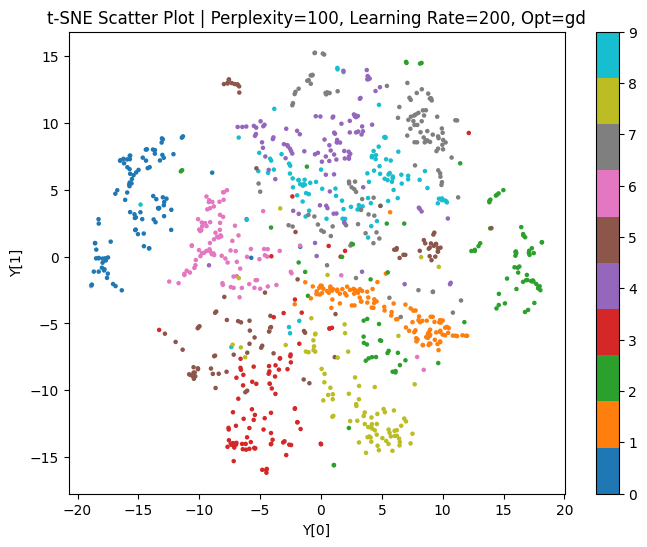

Starting tsne
Iteration 0, Cost: 3.775759220123291
Iteration 10, Cost: 3.775623083114624
Iteration 20, Cost: 3.436937093734741
Iteration 30, Cost: 2.7391858100891113
Iteration 40, Cost: 2.428400993347168
Iteration 50, Cost: 2.236625909805298
Iteration 60, Cost: 2.0999398231506348
Iteration 70, Cost: 1.9924437999725342
Iteration 80, Cost: 1.90531587600708
Iteration 90, Cost: 1.8342559337615967
Iteration 100, Cost: 1.7748093605041504
Iteration 110, Cost: 1.72346830368042
Iteration 120, Cost: 1.67828369140625
Iteration 130, Cost: 1.6382343769073486
Iteration 140, Cost: 1.602372407913208
Iteration 150, Cost: 1.5698686838150024
Iteration 160, Cost: 1.5401625633239746
Iteration 170, Cost: 1.512886643409729
Iteration 180, Cost: 1.487696647644043
Iteration 190, Cost: 1.4642952680587769
Iteration 200, Cost: 1.442428469657898
Iteration 210, Cost: 1.4218919277191162
Iteration 220, Cost: 1.4025481939315796
Iteration 230, Cost: 1.3842473030090332
Iteration 240, Cost: 1.366834044456482
Iteration 250

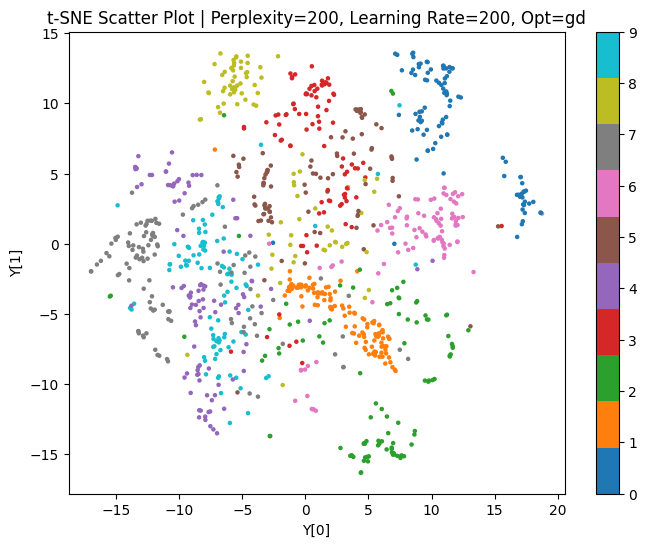

Starting tsne
Iteration 0, Cost: 3.6467392444610596
Iteration 10, Cost: 3.6466012001037598
Iteration 20, Cost: 3.3193376064300537
Iteration 30, Cost: 2.643803358078003
Iteration 40, Cost: 2.3463501930236816
Iteration 50, Cost: 2.162076950073242
Iteration 60, Cost: 2.0319559574127197
Iteration 70, Cost: 1.932289719581604
Iteration 80, Cost: 1.8522783517837524
Iteration 90, Cost: 1.7859373092651367
Iteration 100, Cost: 1.729475975036621
Iteration 110, Cost: 1.6805028915405273
Iteration 120, Cost: 1.637408971786499
Iteration 130, Cost: 1.5989878177642822
Iteration 140, Cost: 1.564332365989685
Iteration 150, Cost: 1.5328972339630127
Iteration 160, Cost: 1.5041948556900024
Iteration 170, Cost: 1.4778356552124023
Iteration 180, Cost: 1.4535350799560547
Iteration 190, Cost: 1.4310098886489868
Iteration 200, Cost: 1.4100137948989868
Iteration 210, Cost: 1.390352487564087
Iteration 220, Cost: 1.3718693256378174
Iteration 230, Cost: 1.3544375896453857
Iteration 240, Cost: 1.337955355644226
Itera

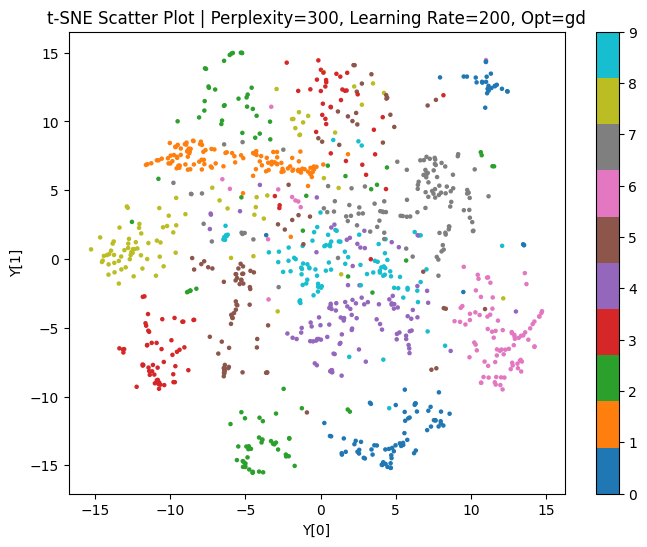

Starting tsne
Iteration 0, Cost: 3.682995080947876
Iteration 10, Cost: 3.6828386783599854
Iteration 20, Cost: 3.3396565914154053
Iteration 30, Cost: 2.676327705383301
Iteration 40, Cost: 2.3781375885009766
Iteration 50, Cost: 2.1945295333862305
Iteration 60, Cost: 2.062009334564209
Iteration 70, Cost: 1.9592193365097046
Iteration 80, Cost: 1.8765349388122559
Iteration 90, Cost: 1.808375358581543
Iteration 100, Cost: 1.7506840229034424
Iteration 110, Cost: 1.700760006904602
Iteration 120, Cost: 1.6567049026489258
Iteration 130, Cost: 1.6173697710037231
Iteration 140, Cost: 1.5820372104644775
Iteration 150, Cost: 1.5500839948654175
Iteration 160, Cost: 1.5209579467773438
Iteration 170, Cost: 1.4941920042037964
Iteration 180, Cost: 1.4693756103515625
Iteration 190, Cost: 1.4462599754333496
Iteration 200, Cost: 1.4246535301208496
Iteration 210, Cost: 1.4043179750442505
Iteration 220, Cost: 1.3851361274719238
Iteration 230, Cost: 1.367022156715393
Iteration 240, Cost: 1.3499062061309814
Ite

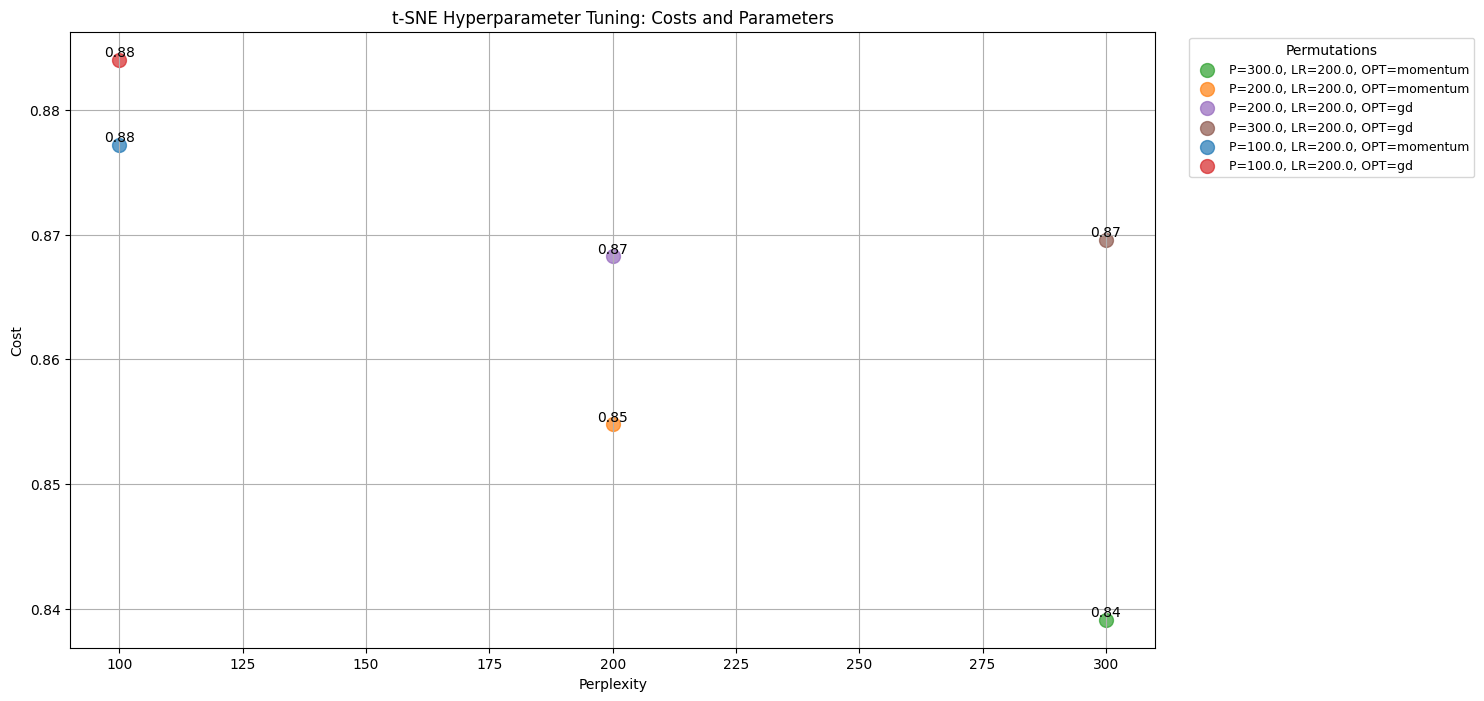

In [14]:
# Define the parameter grid
param_grid = {
    'perplexity': [100, 200, 300],
    'learning_rate': [200],
    'opt': ['momentum', 'gd']
}

# Perform bootstrap validation
best_params, results_array = bootstrap_val_tsne(X_tr, y_tr, param_grid, CustomTSNE, num_bootstraps=5, n_iter=1000)


# Plot the results
plot_all_combinations(results_array)

## t-SNE demonstration 
Demonstrate your t-SNE implementation.

Add plots and figures. The code below is just to help you get started, and should not be your final submission.

Please use the cell below to describe your results and tests.

Describe the difference between your implementation and the sklearn implementation. Hint: you can look at the documentation.

### Demonstration Results

We chose to demonstrate our TSNE implementation on the MNIST dataset with 3 different hyperparameter configurations. 

Unlike the bootstrap sampling for hyperparameter tuning, the demonstration uses 10000 samples and 1000 iterations to ensure a more accurate representation of the data distribution in the lower-dimensional space.

The results are as follows:

#### Perplexity 30, torch mt, 1000 iterations

In [15]:
# run my tsne on the dataset
custom_tsne_30_mt = CustomTSNE(n_iter=1000, perplexity=30, learning_rate=200, opt="mt")
custom_Y_30_mt, costs_30_mt = custom_tsne_30_mt.fit_transform(X_train)

Starting tsne
Iteration 0, Cost: 5.609966278076172
Iteration 10, Cost: 5.609966278076172
Iteration 20, Cost: 5.609963893890381
Iteration 30, Cost: 5.609840393066406
Iteration 40, Cost: 5.6025919914245605
Iteration 50, Cost: 5.391482830047607
Iteration 60, Cost: 4.799160957336426
Iteration 70, Cost: 4.395267486572266
Iteration 80, Cost: 4.1327128410339355
Iteration 90, Cost: 3.9454448223114014
Iteration 100, Cost: 3.80112361907959
Iteration 110, Cost: 3.684328556060791
Iteration 120, Cost: 3.5880467891693115
Iteration 130, Cost: 3.5061757564544678
Iteration 140, Cost: 3.436162233352661
Iteration 150, Cost: 3.3751962184906006
Iteration 160, Cost: 3.321186065673828
Iteration 170, Cost: 3.2729742527008057
Iteration 180, Cost: 3.229440212249756
Iteration 190, Cost: 3.1901392936706543
Iteration 200, Cost: 3.15446138381958
Iteration 210, Cost: 3.1217470169067383
Iteration 220, Cost: 3.091383457183838
Iteration 230, Cost: 3.063598155975342
Iteration 240, Cost: 3.0380477905273438
Iteration 250,

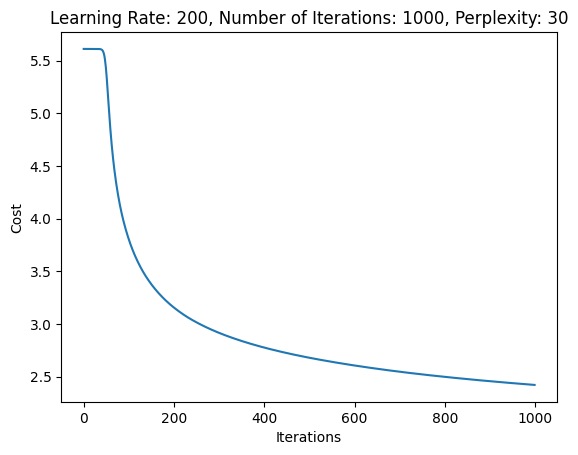

In [16]:
# Plot the cost at each iteration
custom_tsne_30_mt.plots_costs(costs_30_mt)

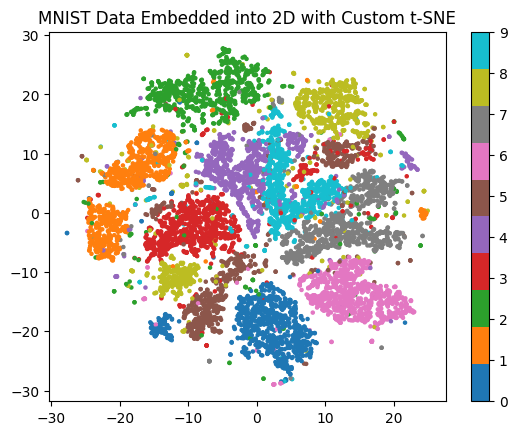

In [17]:
# Plot the tsne outputs
plt.figure()
plt.scatter(custom_Y_30_mt[:, 0], custom_Y_30_mt[:, 1], s=5, c=y_train.astype(int), cmap='tab10')
plt.colorbar()
plt.title('MNIST Data Embedded into 2D with Custom t-SNE')
plt.show()

#### Perplexity 100, torch mt, 1000 iterations

In [18]:
# run my tsne on the dataset
custom_tsne_100_mt = CustomTSNE(n_iter=1000, perplexity=100, learning_rate=200, opt="mt")
custom_Y_100_mt, costs_100_mt = custom_tsne_100_mt.fit_transform(X_train)

Starting tsne
Iteration 0, Cost: 4.431039810180664
Iteration 10, Cost: 4.431039810180664
Iteration 20, Cost: 4.4310383796691895
Iteration 30, Cost: 4.430993556976318
Iteration 40, Cost: 4.428404331207275
Iteration 50, Cost: 4.309494972229004
Iteration 60, Cost: 3.719940662384033
Iteration 70, Cost: 3.2747981548309326
Iteration 80, Cost: 3.0188567638397217
Iteration 90, Cost: 2.8520236015319824
Iteration 100, Cost: 2.736252546310425
Iteration 110, Cost: 2.649099349975586
Iteration 120, Cost: 2.5794918537139893
Iteration 130, Cost: 2.5222198963165283
Iteration 140, Cost: 2.4738500118255615
Iteration 150, Cost: 2.432293653488159
Iteration 160, Cost: 2.395925998687744
Iteration 170, Cost: 2.3634541034698486
Iteration 180, Cost: 2.3338749408721924
Iteration 190, Cost: 2.3066489696502686
Iteration 200, Cost: 2.2814269065856934
Iteration 210, Cost: 2.25797176361084
Iteration 220, Cost: 2.236377239227295
Iteration 230, Cost: 2.2165493965148926
Iteration 240, Cost: 2.198122262954712
Iteration 2

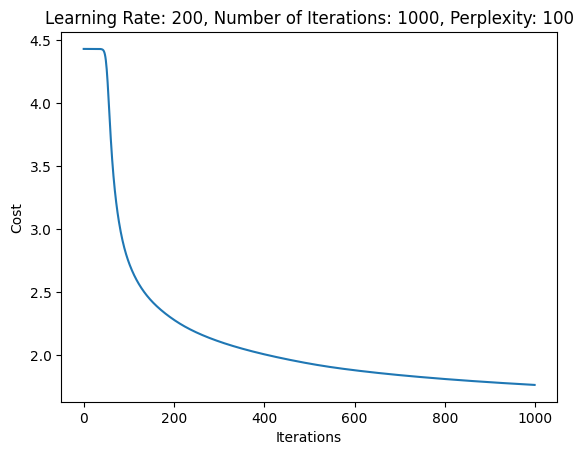

In [19]:
# Plot the cost at each iteration
custom_tsne_100_mt.plots_costs(costs_100_mt)

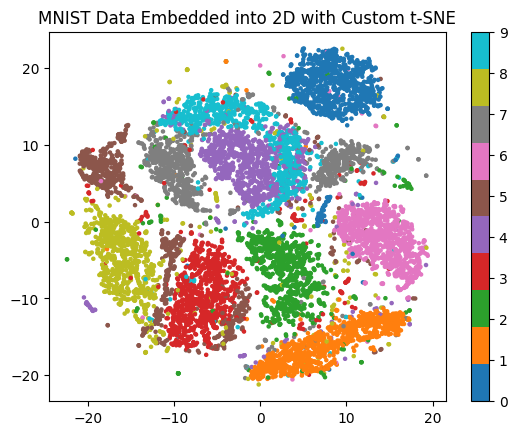

In [20]:
# Plot the tsne outputs
plt.figure()
plt.scatter(custom_Y_100_mt[:, 0], custom_Y_100_mt[:, 1], s=5, c=y_train.astype(int), cmap='tab10')
plt.colorbar()
plt.title('MNIST Data Embedded into 2D with Custom t-SNE')
plt.show()

#### Perplexity 300, torch gd, 1000 iterations

In [21]:
# run my tsne on the dataset
custom_tsne_300_mt = CustomTSNE(n_iter=1000, perplexity=300, learning_rate=200, opt="gd")
custom_Y_300_mt, costs_300_mt = custom_tsne_300_mt.fit_transform(X_train)

Starting tsne
Iteration 0, Cost: 3.401627540588379
Iteration 10, Cost: 3.401627540588379
Iteration 20, Cost: 3.401627540588379
Iteration 30, Cost: 3.401627540588379
Iteration 40, Cost: 3.401627540588379
Iteration 50, Cost: 3.401627540588379
Iteration 60, Cost: 3.401627540588379
Iteration 70, Cost: 3.4016263484954834
Iteration 80, Cost: 3.401624917984009
Iteration 90, Cost: 3.4016189575195312
Iteration 100, Cost: 3.401599645614624
Iteration 110, Cost: 3.4015305042266846
Iteration 120, Cost: 3.4012808799743652
Iteration 130, Cost: 3.4003710746765137
Iteration 140, Cost: 3.397068738937378
Iteration 150, Cost: 3.3856797218322754
Iteration 160, Cost: 3.3521673679351807
Iteration 170, Cost: 3.280203342437744
Iteration 180, Cost: 3.1749346256256104
Iteration 190, Cost: 3.060682773590088
Iteration 200, Cost: 2.955090045928955
Iteration 210, Cost: 2.863199234008789
Iteration 220, Cost: 2.784120798110962
Iteration 230, Cost: 2.7156198024749756
Iteration 240, Cost: 2.6555936336517334
Iteration 25

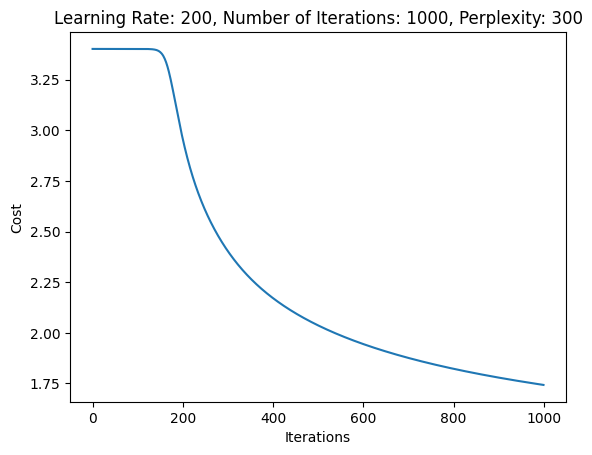

In [22]:
# Plot the cost at each iteration
custom_tsne_300_mt.plots_costs(costs_300_mt)

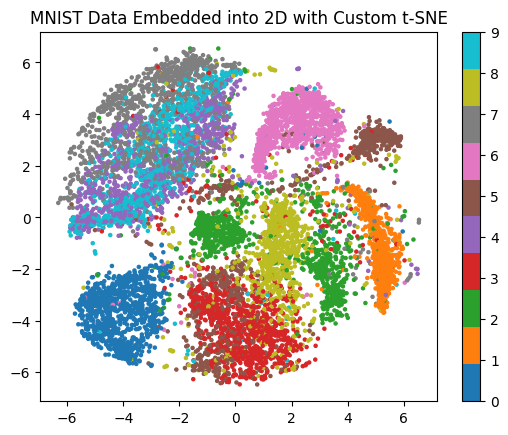

In [23]:
# Plot the tsne outputs
plt.figure()
plt.scatter(custom_Y_300_mt[:, 0], custom_Y_300_mt[:, 1], s=5, c=y_train.astype(int), cmap='tab10')
plt.colorbar()
plt.title('MNIST Data Embedded into 2D with Custom t-SNE')
plt.show()

#### Results and Discussion

Before we compare the results of our implementation with the sklearn implementation, let's point out some key observations:

1. **Clustering**:
   - The t-SNE algorithm effectively clusters the MNIST dataset based on the digits (0–9).
   - The clusters are well-separated, indicating that the algorithm successfully captures the underlying structure of the data.


2. **Label Separation**:
    - The labels are clearly separated in the lower-dimensional space, with distinct clusters for each digit.
    - This separation demonstrates the algorithm's ability to preserve the local structure of the data.
    - We can observe that some clsuters are more separated than others, for example the 0 and 2 digits are very well separated because of their shape, while the 4 and 9 digits are less separated.
    - Some Labels have 2 major clusters (1, 7) because of the different ways to write the digit.


3. **Convergence**:
    - The algorithm converges within the specified number of iterations, reaching a local minimum of the KL divergence.
    - The cost function decreases over time, indicating that the algorithm is optimizing the embeddings effectively.


4. **Hyperparameter Sensitivity**:
    - The choice of hyperparameters significantly impacts the results.
    - Perplexity, learning rate, and optimization algorithm influence the clustering and separation of the data in the lower-dimensional space.
    - By visualizing the different configurations, the best results are for perplexity 100, torch mt, 1000 iterations. for perplexity 30, torch mt, 1000 the clusters are well separated but the labels are not as clear as in the perplexity 100, and for perplexity 300, torch gd, 1000 the clusters are not as separated as in the other configurations.


5. **Scalability**:
    - The algorithm scales well to 10000 samples, demonstrating its efficiency for large datasets.
    - The vectorized implementation and PyTorch optimizers contribute to the algorithm's scalability.

6. **Running Time**:
    - The algorithm runs in a reasonable time for 10000 samples and 1000 iterations (~30 minutes), demonstrating its efficiency and effectiveness for practical applications.
    - Future optimizations such as parallel processing, GPU acceleration, or batch processing could further enhance the algorithm's performance.
    - Additional changing to the algorithm such as calculating the pairwise distances only in "neighbors" of the data points could improve the running time.






# Part 4: Compare to Existing Implementations

In [24]:
# Run sklearn t-SNE
sk_tsne = TSNE(n_components=2, init='random', perplexity=100, max_iter=1000, learning_rate=200)
sk_Y = sk_tsne.fit_transform(X_train)

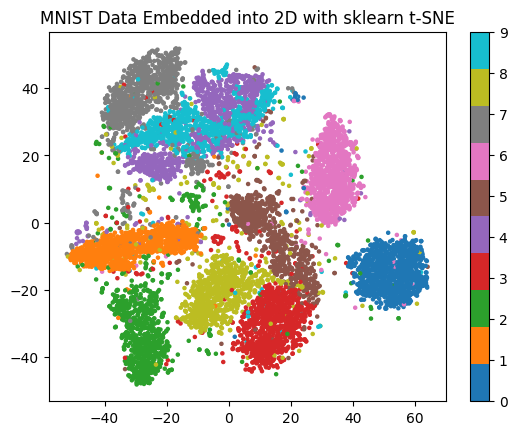

In [25]:
# Visualization of the result
plt.figure()
plt.scatter(sk_Y[:, 0], sk_Y[:, 1], s=5, c=y_train.astype(int), cmap='tab10')
plt.colorbar()
plt.title('MNIST Data Embedded into 2D with sklearn t-SNE')
plt.show()

## Comparison with scikit-learn implementation
We chose to compare our custom t-sne and sklearn's tsne with perplexity 100 and learning_rate 200.

## 1. Visual Results Comparison
- In our custom t-SNE implementation, the clusters are distinct and grouped correctly, showing that the algorithm effectively captures local structures. Some minor overlaps between clusters suggest there’s room for improvement.

- The scikit-learn t-SNE implementation produces more spread-out clusters with slightly clearer separations.

**Conclusion**: Our implementation successfully clusters the data and provides meaningful low-dimensional embeddings. With further refinement — it can rival scikit-learn.

---

### 2. Computational Performance
- Our custom t-SNE makes use of vectorized operations, which makes it efficient for smaller datasets.

- Scikit-learn t-SNE, by comparison, is optimized for large datasets, leveraging Barnes-Hut approximation, efficient C++ backend, early exaggeration, multithreading, efficient memory management, optimized numerical calculations, etc.

**Conclusion**: while for smaller datasets both implementations converge in a reasonable time, for larger datasets sklearn is superior

---

### 3. Quality of Embeddings
- Our implementation demonstrates consistent KL divergence reduction during optimization. The embeddings value range are in [-20,20]

- Scikit-learn’s showcase better global structure preservation with embeddings value range in [-80, 80].

### 4. Final Thoughts
- As mentioned briefly in Section 2, there are many techniques stemming from practical experience with real-world data. To demonstrate this, we can dive into two important methods implemented in scikit-learn's t-SNE, which are not part of the main algorithm described in the original paper:
    1. **Early Exaggeration**: This technique multiplies \(P\) by a factor (the default in scikit-learn is 12) in the initial stage of the optimization. "The effect is that the natural clusters in the data tend to form tight, widely separated clusters in the map. This creates a lot of relatively empty space in the map, which makes it much easier for the clusters to move around relative to one another in order to find a good global organization."
    2. **Dynamic \(P\) Normalization**: In the paper, normalization is fixed based on the dataset size. However, in practice, dynamically adjusting the normalization based on the computed values of \(P\) ensures robustness to floating-point precision and other variations.

- There are many more techniques implemented in the scikit-learn package, accumulating years of knowledge and experience. Our implementation, however, focuses on covering the main concepts of t-SNE and demonstrating its correctness.

These techniques are the direct reason for the discrepancy in embedding quality and computation time.


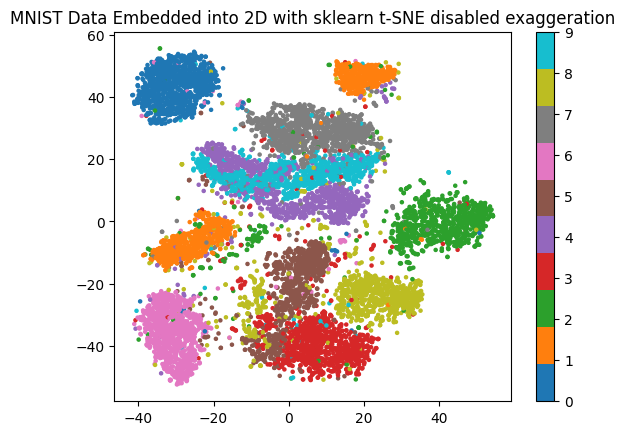

In [26]:
# Showcasing the Strength of Early Exaggeration for t-SNE Results. Early exaggeration is a powerful technique that significantly improves t-SNE results. It is just one of many computational enhancements and strategies designed to refine the quality and efficiency of t-SNE embeddings. This is one of the reasons for faster computations, improved results and larger embeddings range

# Run sklearn t-SNE with 'disabled' early exaggeration
sk_tsne = TSNE(n_components=2, init='random', perplexity=100, max_iter=1000, learning_rate=200, early_exaggeration=1)
sk_Y = sk_tsne.fit_transform(X_train)

# Visualization of the result
plt.figure()
plt.scatter(sk_Y[:, 0], sk_Y[:, 1], s=5, c=y_train.astype(int), cmap='tab10')
plt.colorbar()
plt.title('MNIST Data Embedded into 2D with sklearn t-SNE disabled exaggeration')
plt.show()


# Part 5: Mapping New Data Points
Demonstrate your t-SNE transformation procedure.

Add plots and figures.

Please use the cell below t describe your suggested approach in detail. Use formal notations where appropriate.
Describe and discuss your results.



### Methodology

To embed \( m \) new data points into an already computed t-SNE 2D map, we extend our algorithm with the following method:

1. **Compute Euclidean Distances**:
   - For each new data point, compute its Euclidean distance to all \( n \) original training points. 
   - This is done vectorized for efficiency using the formula:
     $$
     D_{ij} = \|x_i - x_j\|^2 = \|x_i\|^2 + \|x_j\|^2 - 2x_i^T x_j
     $$
   - The result is a distance matrix of shape \( m * n \).

2. **Compute Betas for Gaussian Bandwidth**:
   - Using binary search, determine the appropriate $\beta = \frac{1}{2\sigma^2}$ for each new point based on the t-SNE perplexity.
   - This ensures that the distribution of distances aligns with the target perplexity.

3. **Compute Affinities**:
   - Calculate the affinities for each new data point based on the computed \( \beta \) and the Euclidean distances. The affinity for a new point \( i \) and an original point \( j \) is given by:
     $$
     A_{ij} = \exp(-\beta_i D_{ij})
     $$

4. **Infer Low-Dimensional Embedding**:
   - **Step 1: Normalize Row-Wise**:
     - Normalize the affinities row-wise to ensure they sum to 1. For each new point \( i \), divide each affinity by the sum of all affinities for that point:
       $$
       A_{ij} = \frac{A_{ij}}{\sum_{k} A_{ik}}
       $$
   - **Step 2: Compute Low-Dimensional Embedding**:
     - Using the normalized affinities and the precomputed low-dimensional embeddings $Y_{\text{original}} $, compute the new embeddings:
       $$
       Y_{\text{new}} = A \cdot Y_{\text{original}}
       $$
     - This ensures that the relative distances in the low-dimensional space are preserved with respect to the original embeddings.

5. **Return the Result**:
   - The resulting $Y_{\text{new}}$ matrix provides the 2D (or low-dimensional) representation of the new points.

---

### Summary

The proposed method efficiently computes the low-dimensional embeddings for new data points by leveraging the relationships between the original training data and their low-dimensional transformations. The result maintains the local relationships between the new data points and the training data while preserving the structure learned by the original t-SNE mapping.


## Results and Visualization

We present the results of our method for embedding new data points into an existing t-SNE map. The results are shown for two perplexity values: **30** and **100**, using the **momentum optimizer**.

- The **original points** are displayed as circles.
- The **new points** are marked as stars, overlayed on the original points for reference.

This visualization demonstrates how well the new points align with the structure learned by the t-SNE mapping for different perplexity values.


#### Perplexity 30, torch mt, 1000 iterations

Text(0.5, 1.0, 'MNIST Data Embedded into 2D with Custom t-SNE')

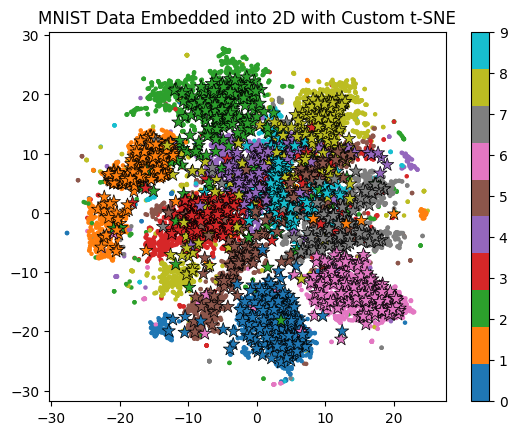

In [27]:
# Transform new data
custom_Y_new_30_mt = custom_tsne_30_mt.transform(X_train,custom_Y_30_mt,X_test)

# Visualization of the result
plt.figure()
plt.scatter(custom_Y_30_mt[:, 0], custom_Y_30_mt[:, 1], s=5, c=y_train.astype(int), cmap='tab10')
plt.scatter(custom_Y_new_30_mt[:, 0], custom_Y_new_30_mt[:, 1], marker = '*', s=100, linewidths=0.5, edgecolors='k', c=y_test.astype(int), cmap='tab10')
plt.colorbar()
plt.title('MNIST Data Embedded into 2D with Custom t-SNE')

#### Perplexity 100, torch mt, 1000 iterations

Text(0.5, 1.0, 'MNIST Data Embedded into 2D with Custom t-SNE')

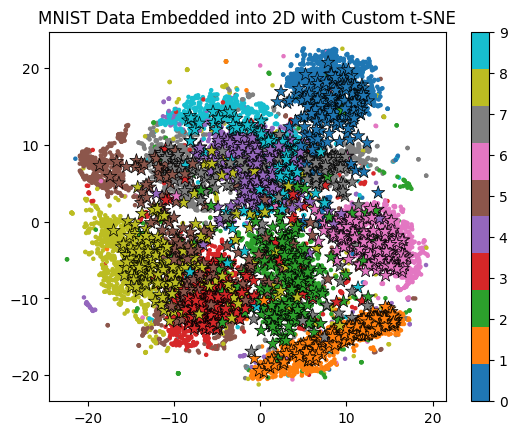

In [28]:
# Transform new data
custom_Y_new_100_mt = custom_tsne_100_mt.transform(X_train,custom_Y_100_mt,X_test)

# Visualization of the result
plt.figure()
plt.scatter(custom_Y_100_mt[:, 0], custom_Y_100_mt[:, 1], s=5, c=y_train.astype(int), cmap='tab10')
plt.scatter(custom_Y_new_100_mt[:, 0], custom_Y_new_100_mt[:, 1], marker = '*', s=100, linewidths=0.5, edgecolors='k', c=y_test.astype(int), cmap='tab10')
plt.colorbar()
plt.title('MNIST Data Embedded into 2D with Custom t-SNE')

#### Results and Discussion

- The new data points are effectively embedded into the existing t-SNE map, aligning with the local structure of the original data.

- For perplexity 30, the new points are well-distributed across the clusters, indicating that the local relationships are preserved effectively.

- For perplexity 100, the new points are more concentrated around the clusters, reflecting the higher perplexity value and the broader neighborhood considered for each point.

- The results demonstrate the robustness and flexibility of the t-SNE algorithm in embedding new data points while maintaining the structure learned from the original data.

- The method effectively extends the t-SNE mapping to new data points, providing a comprehensive view of the data distribution in the lower-dimensional space.

- For both perplexity values (30, 100), the new points align well with the original data, showcasing the algorithm's ability to generalize and capture the underlying structure of the data.

# Use of generative AI
Please use the cell below to describe your use of generative AI in this assignment. 


Generative AI was utilized in several aspects of the project to improve efficiency, ensure accuracy, and enhance the overall quality of the implementation. The key contributions include:

1. **Documentation**:
   - Provided clear and structured documentation for methods, algorithms, and processes, ensuring that all components of the project are well-explained and accessible.

2. **Recommendations for Methodology and Implementation**:
   - Offered suggestions on methodological approaches and implementation strategies, including hyperparameter tuning, optimizers, and code structuring.

3. **Possible Values for Parameters**:
   - Assisted in identifying reasonable ranges and initial values for critical parameters, such as learning rate, perplexity, and the number of iterations, based on best practices and domain knowledge.

4. **Debugging**:
   - Helped identify and resolve errors or inefficiencies in the code, providing alternative solutions and explanations for potential issues.

5. **Optimizers**:
   - Suggested suitable optimizers (e.g., SGD, momentum) for gradient descent in the t-SNE algorithm and explained their applicability based on the dataset and computational requirements.

6. **General Structure of the Code**:
   - Recommended an object-oriented design for the t-SNE algorithm and proposed helper functions for modularity and reusability, enhancing the scalability and maintainability of the code.

7. **Proofreading of Texts**:
   - Reviewed and refined textual content, ensuring clarity, coherence, and professionalism in all written materials, including explanations, documentation, and results presentation.

